In [135]:
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import operator
from geopy.distance import geodesic


routes_columns = ["airline", "airline id","from", "from id",
                 "to", "to id", "codesh", "stops", "equip"]
data = pd.read_csv('routes.txt', sep=",", header=None)
routes = data[[2,4]]
routes.insert(2, "Route", routes[2]+routes[4], True)

routes.insert(2, "count", routes.groupby('Route')['Route'].transform('count'), True)
routes = routes.drop_duplicates()
routes.sort_values(by=['Route'])
routes = routes.rename(columns={2:"from", 4:"to"})

G = nx.convert_matrix.from_pandas_edgelist(routes, "from", "to", edge_attr='count')

print(G.number_of_edges())
print(G.number_of_nodes())

# find where airplanes are born and which are the absorbing states
a = routes["from"].drop_duplicates()
a = a.tolist()
b = routes["to"].drop_duplicates()
b = b.tolist()
set(a) - set(b)
set(b) - set(a)


# Get connected components

graphs = list(nx.connected_component_subgraphs(G))
G1 = graphs[0] ## Main component

## Merge with airport data

airport_cols = ('airport_id', 'airport_name', 'city', 'country', 'iata', 'icao', 'latitude', 'longitude', 'altitude', 'timezone', 'dst',
               "Tz database time zone",'Type','source')
airports = pd.read_csv('airports.txt',  names = airport_cols,header = None)

routes = routes.merge(airports, left_on = "from", right_on = "iata") \
.merge(airports, left_on='to', right_on='iata', suffixes=('_source', '_dest'))

routes['distance'] = routes.apply(lambda x: geodesic((x['latitude_source'], x['longitude_source']),
                                                 (x['latitude_dest'], x['longitude_dest'])), axis = 1)

### Add graph information

edge_betw = nx.edge_betweenness_centrality(G)

df = pd.DataFrame.from_dict(edge_betw, orient = 'index',columns = ["betweenness"])
df.index = [c[0]+c[1] for c in edge_betw.keys()]
routes = routes.merge(df, left_on = "Route", right_index = True)
routes["distance"] = routes["distance"].astype(str).str[:-3].astype(float)



#### AIRPORT DATA
nodes_degree = dict(nx.degree(G))

df_c = pd.DataFrame.from_dict(nodes_clustering, orient = 'index', columns = ["clustering"])
airports = airports.merge(df_c, left_on = "iata", right_index = True)

df_d = pd.DataFrame.from_dict(nodes_degree, orient = 'index', columns = ["degree"])
airports = airports.merge(df_d, left_on = "iata", right_index = True)

19257
3425


NameError: name 'edge_betw' is not defined

In [41]:
n_nodes = len(G1.nodes()) ## number of nodes in the main component
n_edges = len(G1.edges()) ## number of edges in the main component
print(nx.average_clustering(G1)) ## average clustering coefficient

mean_of_randoms = np.mean([nx.average_clustering(nx.gnm_random_graph(n_nodes, n_edges)) for c in range(100)])

0.4883362024529614


KeyboardInterrupt: 

In [25]:
average_shortest_path = nx.average_shortest_path_length(G1)
random_average_shortest_path = np.mean([nx.average_shortest_path_length(nx.gnm_random_graph(n_nodes, n_edges)) for c in range(1)])

In [94]:
###  Airline data
routes_columns = ["airline", "airline id","from", "from id",
                 "to", "to id", "codesh", "stops", "equip"]
data = pd.read_csv('routes.txt', sep=",", header=None, names = routes_columns)

airline_destinations = data.groupby("airline")["to"].nunique()
airline_n_routes = round(data.airline.value_counts() / 2)
big_airlines = airline_destinations[airline_destinations > 50].keys()

graphs = {}
for c in big_airlines:
    graphs[c] = nx.convert_matrix.from_pandas_edgelist(data[data["airline"] == c], "from", "to")

def create_spring_layout(G, Y,n):
    pos_spring = nx.spring_layout(G)
    plt.figure(figsize= (10,10))
    nx.draw_networkx_nodes(G, pos_spring, alpha = 0.5, node_size= [v*10 for v in dict(G.degree).values()])
    
    nx.draw_networkx_edges(G, pos_spring, alpha=0.2)
    plt.title("")
    plt.show()

#create_spring_layout(graphs["KL"], "blue", 1)

airline_df = pd.DataFrame(index=data["airline"].unique())
airline_df = airline_df.merge(data.groupby("airline")["to"].nunique(), left_index = True, right_index = True)

densities = {}
for c in graphs:
    densities[c] = nx.density(graphs[c])
    
clust = {}
for c in graphs:
    clust[c] = nx.clustering(graphs[c])
    
airline_df = airline_df.merge(pd.DataFrame.from_dict(densities, orient= "index", columns = ["density"]), left_index = True, right_index = True)

avg_shortest = {}
diameters = {}
for c in graphs:
    if nx.is_connected(graphs[c]):
        avg_shortest[c] = nx.average_shortest_path_length(graphs[c])
        diameters[c] = nx.diameter(graphs[c]) 
    else:
        g = list(nx.connected_component_subgraphs(graphs[c]))[0]
        avg_shortest[c] = nx.average_shortest_path_length(g)
        diameters[c] = nx.diameter(g)      
    
airline_df = airline_df.merge(pd.DataFrame.from_dict(avg_shortest, orient= "index", columns = ["short path"]), left_index = True, right_index = True)




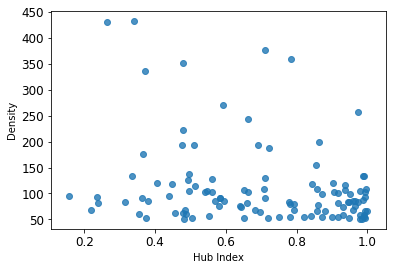

array([[ 1.        , -0.44454183],
       [-0.44454183,  1.        ]])

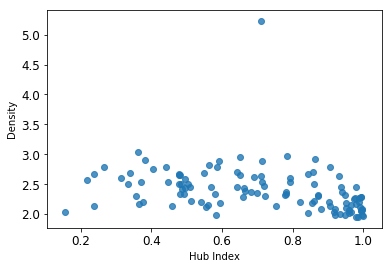

In [153]:
#plt.scatter(airline_df.HI[airline_df.to > 100], airline_df.density[airline_df.to > 100])
plt.scatter(airline_df.HI, airline_df["to"], alpha = 0.8)
plt.xlabel("Hub Index")
plt.ylabel("Density")
plt.show()
plt.scatter(airline_df.HI, airline_df["short path"], alpha = 0.8)
plt.xlabel("Hub Index")
plt.ylabel("Density")

np.corrcoef(airline_df.HI[airline_df["short path"] < 4], airline_df["short path"][airline_df["short path"] < 4])

#airline_df[airline_df.to > 150]

In [150]:
from scipy import stats
stats.linregress(airline_df.density, airline_df.HI)

LinregressResult(slope=-4.723529617521266, intercept=0.9055392799291248, rvalue=-0.4511095653184402, pvalue=6.736058036617563e-07, stderr=0.8950850255337223)

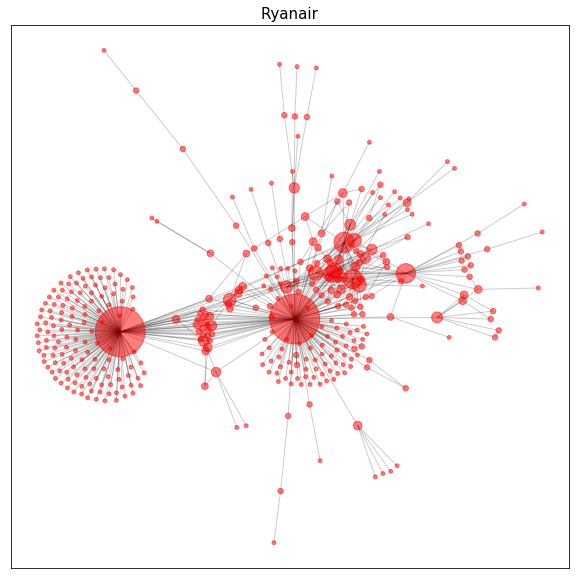

airline airline id from from id   to to id codesh  stops    equip
15030      BE       2421  ABZ     532  BHD   467    NaN      0      DH4
15031      BE       2421  ABZ     532  BHX   469    NaN      0  E75 DH4
15032      BE       2421  ABZ     532  CDG  1382      Y      0      EMJ
15033      BE       2421  ABZ     532  KOI   529      Y      0  S20 SF3
15034      BE       2421  ABZ     532  LSI   530      Y      0  SF3 S20
...       ...        ...  ...     ...  ...   ...    ...    ...      ...
15293      BE       2421  TAY     416  HEL   421    NaN      0      AT7
15294      BE       2421  TRE     542  GLA   534      Y      0  SF3 DHT
15295      BE       2421  WAT     605  BHX   469    NaN      0      DH4
15296      BE       2421  WAT     605  MAN   478    NaN      0      DH4
15297      BE       2421  WIC     531  EDI   535      Y      0      D38

[268 rows x 9 columns]

In [71]:
def create_spring_layout(G, Y,n):
    pos_spring = nx.spring_layout(G)
    plt.figure(figsize= (10,10))
    plt.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,
        left=False,# ticks along the top edge are off
        labelbottom=False,
        labelleft = False)
        
    labels = {}
    #labels["ATL"] = "ATL"
    #labels["AMS"] = "AMS"
    nx.draw_networkx_nodes(G, pos_spring, alpha = 0.5, node_size= [v*15 for v in dict(G.degree).values()])
    nx.draw_networkx_edges(G, pos_spring, alpha=0.2)
    nx.draw_networkx_labels(G, pos_spring, labels = labels, fontsize = 15)

    plt.title("Ryanair", fontsize = 15)
    plt.show()

create_spring_layout(graphs["AF"], "blue", 1)

clust = {}
for c in graphs:
    clust[c] = nx.average_clustering(graphs[c])
    
data[data["airline"] == "BE"]

{'3U': 0.05362517099863201,
 '4U': 0.04387602688573562,
 '5J': 0.05974025974025974,
 '7H': 0.03248924988055423,
 '9W': 0.05333333333333334,
 'A3': 0.03635183382018825,
 'AA': 0.01267547173827439,
 'AB': 0.046251993620414676,
 'AC': 0.019113229047964364,
 'AD': 0.03940982333527471,
 'AF': 0.007551110575571354,
 'AH': 0.054274084124830396,
 'AI': 0.03902531886541024,
 'AK': 0.0544464609800363,
 'AM': 0.025404420141262245,
 'AR': 0.05194805194805195,
 'AS': 0.02887505367110348,
 'AT': 0.036414565826330535,
 'AV': 0.04202174551866,
 'AY': 0.02303210947026148,
 'AZ': 0.011857707509881422,
 'B6': 0.05471956224350205,
 'BA': 0.013558991367117008,
 'BE': 0.055900621118012424,
 'BR': 0.04122990915443746,
 'BT': 0.039133473095737246,
 'CA': 0.035897144157469564,
 'CI': 0.03258052573121066,
 'CM': 0.03850931677018633,
 'CX': 0.02202020202020202,
 'CZ': 0.039345854922279794,
 'DE': 0.08605769230769231,
 'DL': 0.016052880075542966,
 'DY': 0.05591147350029121,
 'EI': 0.03320599471054952,
 'EK': 0.01

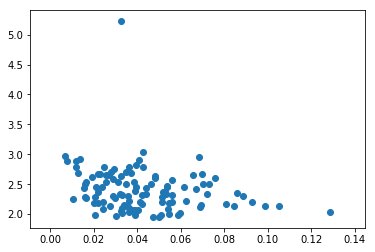

In [51]:
plt.scatter(airline_df["density"], airline_df["short path"])
densities

In [37]:
airports = pd.read_csv('airports.txt',  names = airport_cols,header = None)
airports = airports.set_index("iata")

nodes_clustering = nx.clustering(G)

nodes_clustering

nodes_degree = dict(nx.degree(G))
nodes_clustering

df_c = pd.DataFrame.from_dict(nodes_clustering, orient = 'index', columns = ["clustering"])
airports = airports.merge(df_c, left_on = "iata", right_index = True)
df_d = pd.DataFrame.from_dict(nodes_degree, orient = 'index', columns = ["degree"])
airports = airports.merge(df_d, left_on = "iata", right_index = True)


#for a in airports["iata"]:
#    print()



In [217]:
cc  = nx.closeness_centrality(G1)

In [38]:
##bc = nx.betweenness_centrality(G1)

##df_c = pd.DataFrame.from_dict(cc, orient = 'index', columns = ["closensess"])
##airports = airports.merge(df_c, left_index = True, right_index = True)
df_d = pd.DataFrame.from_dict(bc, orient = 'index', columns = ["betweenness"])
airports = airports.merge(df_d, left_index = True, right_index = True)
#airports = airports.merge(pd.DataFrame.from_dict(dict(nx.degree(G1)), orient = "index", columns = ["degree"]), 
                          #left_index = True, right_index = True)

ai

In [133]:
airports[airports.betweenness > 0.04]

airport_id                                       airport_name  \
YYZ         193            Lester B. Pearson International Airport   
FRA         340                          Frankfurt am Main Airport   
AMS         580                         Amsterdam Airport Schiphol   
CDG        1382            Charles de Gaulle International Airport   
DXB        2188                        Dubai International Airport   
GRU        2564  Guarulhos - Governador André Franco Montoro In...   
PEK        3364              Beijing Capital International Airport   
LAX        3484                  Los Angeles International Airport   
SEA        3577               Seattle Tacoma International Airport   
ANC        3774        Ted Stevens Anchorage International Airport   
ORD        3830               Chicago O'Hare International Airport   
IST       13696                                   Istanbul Airport   

            city               country  icao   latitude   longitude  altitude  \
YYZ      Toronto                Canada  CYYZ  43.677200  -79.630600       569   
FRA    Frankfurt               Germany  EDDF  50.033333    8.570556       364   
AMS    Amsterdam           Netherlands  EHAM  52.308601    4.763890       -11   
CDG        Paris                France  LFPG  49.012798    2.550000       392   
DXB        Dubai  United Arab Emirates  OMDB  25.252800   55.364399        62   
GRU    Sao Paulo                Brazil  SBGR -23.435556  -46.473057      2459   
PEK      Beijing                 China  ZBAA  40.080101  116.584999       116   
LAX  Los Angeles         United States  KLAX  33.942501 -118.407997       125   
SEA      Seattle         United States  KSEA  47.449001 -122.308998       433   
ANC    Anchorage         United States  PANC  61.174400 -149.996002       152   
ORD      Chicago         United States  KORD  41.978600  -87.904800       672   
IST     Istanbul                Turkey  LTFM  41.275278   28.751944       325   

    timezone dst Tz database time zone     Type       source  clustering  \
YYZ       -5   A       America/Toronto  airport  OurAirports    0.192060   
FRA        1   E         Europe/Berlin  airport  OurAirports    0.146968   
AMS        1   E      Europe/Amsterdam  airport  OurAirports    0.148328   
CDG        1   E          Europe/Paris  airport  OurAirports    0.144212   
DXB        4   U            Asia/Dubai  airport  OurAirports    0.137957   
GRU       -3   S     America/Sao_Paulo  airport  OurAirports    0.168419   
PEK        8   U         Asia/Shanghai  airport  OurAirports    0.121992   
LAX       -8   A   America/Los_Angeles  airport  OurAirports    0.182024   
SEA       -8   A   America/Los_Angeles  airport  OurAirports    0.252345   
ANC       -9   A     America/Anchorage  airport  OurAirports    0.096257   
ORD       -6   A       America/Chicago  airport  OurAirports    0.125219   
IST        3   E                    \N  airport  OurAirports    0.113559   

     degree  betweenness  
YYZ     147     0.043357  
FRA     244     0.051932  
AMS     248     0.050078  
CDG     240     0.062962  
DXB     188     0.057423  
GRU      92     0.041052  
PEK     207     0.050390  
LAX     149     0.066288  
SEA      94     0.048904  
ANC      34     0.073683  
ORD     206     0.048734  
IST     236     0.042429

In [106]:
MC = 100
values = np.zeros((0,2))
for n in range(MC):
    g = nx.expected_degree_graph(list(dict(nx.degree(G)).values()))
    betw_c = nx.betweenness_centrality(g)
    deg_c = nx.degree(g)
    values = np.append(values,np.vstack((np.array(list(betw_c.values())),np.array(list(deg_c))[:,1])).T, axis = 0)
    

plt.scatter(values[:,1], values[:,0])

KeyboardInterrupt: 

Text(0,0.5,'Betweenness centrality')

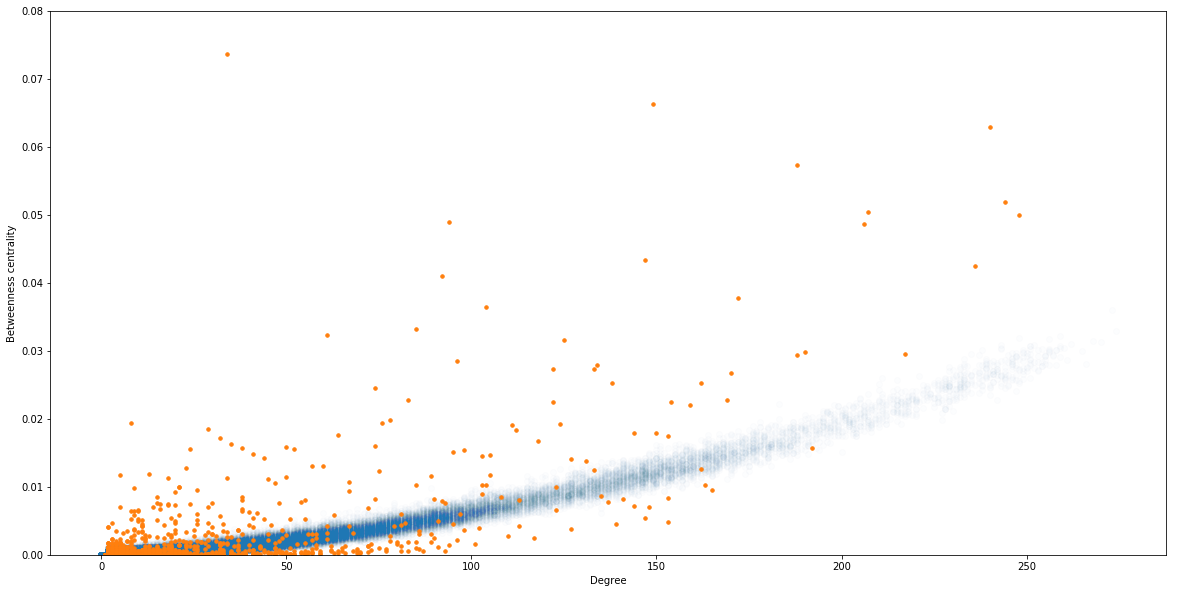

In [131]:
plt.figure(figsize = (20,10))
plt.scatter(values[:,1], values[:,0], alpha = 0.01)
plt.scatter(airports["degree"], airports["betweenness"], s= 12)
plt.ylim((0,0.08))
plt.xlabel("Degree")
plt.ylabel("Betweenness centrality")

In [71]:
d = nx.degree(g)
print(np.array(list(betw_c.values())).shape)
print(np.array(list(d)))
np.vstack((np.array(list(betw_c.values())),np.array(list(d))[:,1])).T

(3397,)
[[   0   14]
 [   1   13]
 [   2   16]
 ...
 [3394    9]
 [3395   20]
 [3396   14]]


array([[1.06965065e-03, 1.40000000e+01],
       [9.10592938e-04, 1.30000000e+01],
       [1.44076483e-03, 1.60000000e+01],
       ...,
       [4.32174001e-04, 9.00000000e+00],
       [2.20170158e-03, 2.00000000e+01],
       [1.08506006e-03, 1.40000000e+01]])

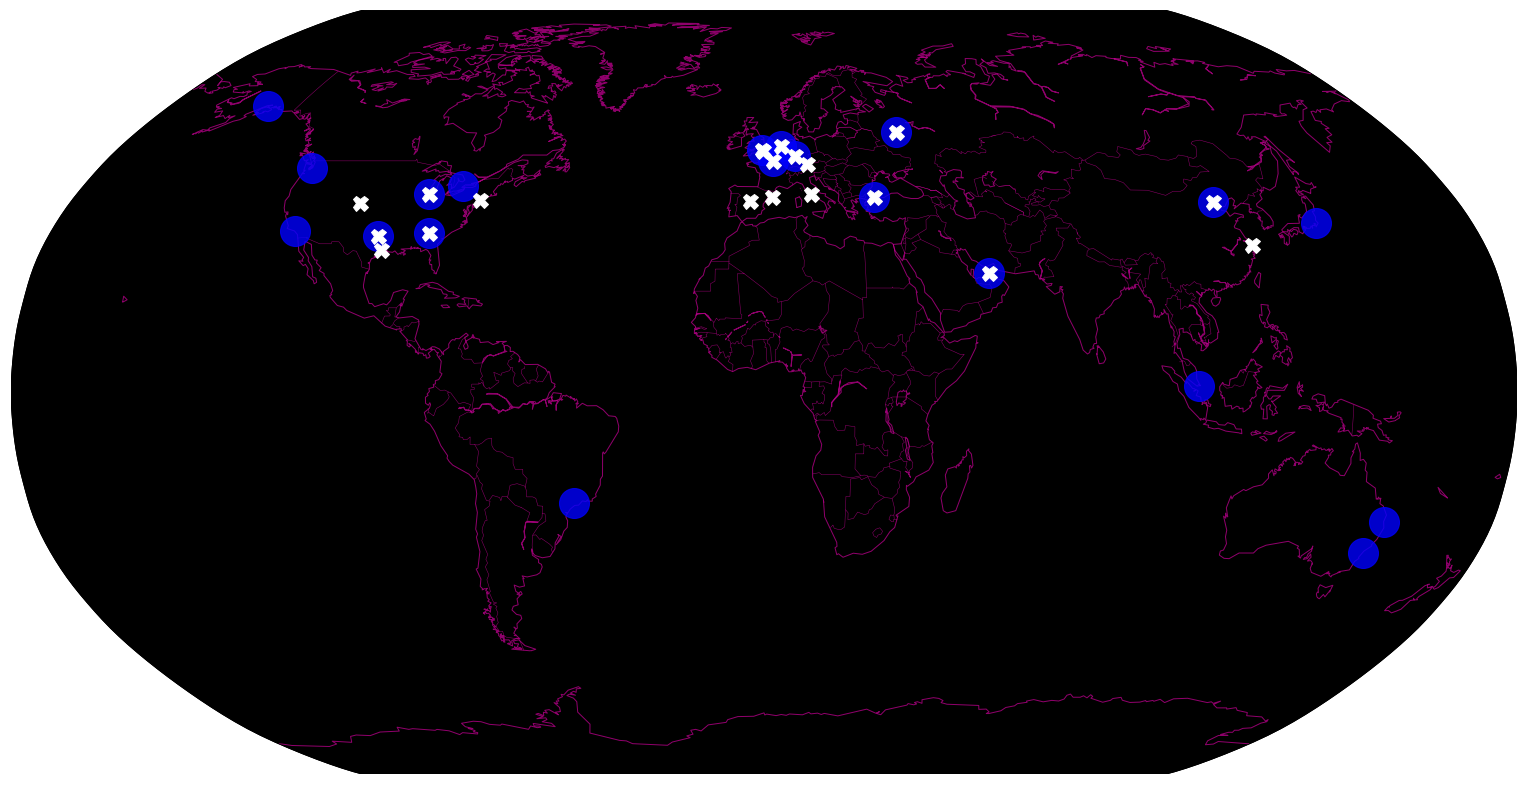

In [296]:
#plt.scatter(airports["degree_x"], airports["betweenness_x"])

top25_deg = airports.nlargest(20, "degree_x")
top25_betw = airports.nlargest(20, "betweenness_x")

bg_color = (0.0, 0.0, 0, 1.0)
coast_color = (204/255.0, 0, 153/255.0, 0.7)



plt.figure(figsize=(27, 20))
m = Basemap(projection='robin', lon_0=0)
m.drawcoastlines(color=coast_color, linewidth=1.0)
m.fillcontinents(color=bg_color, lake_color=bg_color)
m.drawmapboundary(fill_color=bg_color)
m.drawcountries(color = coast_color)
x,y = m(list(top25_betw["longitude"]), list(top25_betw["latitude"]))
m.plot(x,y,"bo", markersize = 30, alpha = 0.8)
x,y = m(list(top25_deg["longitude"]), list(top25_deg["latitude"]))
m.plot(x,y,"wX", markersize = 15)


In [29]:
top25_deg

NameError: name 'top25_deg' is not defined

In [ ]:
from matplotlib.colors import Normalize, LinearSegmentedColormap, PowerNorm
import mpl_toolkits
from mpl_toolkits.basemap import Basemap


def plot_map_points(data_file, color_mode='screen',
             out_filename='flights_map_mpl.png', absolute=False,
            points = False):

    if color_mode == 'screen':
        bg_color = (0.0, 0.0, 0, 1.0)
        coast_color = (204/255.0, 0, 153/255.0, 0.7)
        color_list = [(0.0, 0.0, 0.0, 0.0),
                      (204/255.0, 0, 153/255.0, 0.6),
                      (255/255.0, 204/255.0, 230/255.0, 1.0)]
    else:
        bg_color = (1.0, 1.0, 1.0, 1.0)
        coast_color = (10.0/255.0, 10.0/255.0, 10/255.0, 0.8)
        color_list = [(1.0, 1.0, 1.0, 0.0),
                      (255/255.0, 204/255.0, 230/255.0, 1.0),
                      (204/255.0, 0, 153/255.0, 0.6)
                      ]
        
    points = data_file[["latitude", "longitude"]]


    num_routes = len(routes.index)

    # normalize the dataset for color scale
    norm = PowerNorm(0.3, routes['count'].min(),
                     routes['count'].max())

    # create a linear color scale with enough colors
    if absolute:
        n = routes['count'].max()
    else:
        n = num_routes
    cmap = LinearSegmentedColormap.from_list('cmap_flights', color_list,
                                             N=n)
    # create the map and draw country boundaries
    plt.figure(figsize=(27, 20))
    m = Basemap(projection='robin', lon_0=0)
    m.drawcoastlines(color=coast_color, linewidth=1.0)
    m.fillcontinents(color=bg_color, lake_color=bg_color)
    m.drawmapboundary(fill_color=bg_color)

    # plot each route with its color depending on the number of flights
    for i, route in enumerate(routes.sort_values(by='count',
                              ascending=True).iterrows()):
        route = route[1]
        if absolute:
            color = cmap(norm(int(route['count'])))
        else:
            color = cmap(i * 1.0 / num_routes)

        line, = m.drawgreatcircle(route['longitude_source'], route['latitude_source'], 
                                  route['longitude_dest'], route['latitude_dest'],linewidth=2, color="green",
                                 alpha = 0.4)
         #if the path wraps the image, basemap plots a nasty line connecting
         #the points at the opposite border of the map.
         #we thus detect path that are bigger than 30km and split them
         #by adding a NaN
        path = line.get_path()
        cut_point, = np.where(np.abs(np.diff(path.vertices[:, 0])) > 30000e3)
        if len(cut_point) > 0:
            cut_point = cut_point[0]
            vertices = np.concatenate([path.vertices[:cut_point, :],
                                     [[np.nan, np.nan]],
                                      path.vertices[cut_point+1:, :]])
            path.codes = None  # treat vertices as a serie of line segments
            path.vertices = vertices

    # save the map
    plt.savefig(out_filename, format='png', bbox_inches='tight')

#def plot_route(steps, data):
#    indices = []
#    for s,j in enumerate(steps[:len(steps)]):
#        indices.add(routes[])

In [233]:
hel_lengths = nx.single_source_shortest_path_length(G, "HEL")
np.mean(list(hel_lengths.values()))

2.9166911981159847

In [79]:
from matplotlib.colors import Normalize, LinearSegmentedColormap, PowerNorm
import mpl_toolkits
from mpl_toolkits.basemap import Basemap


def plot_map(data_file, color_mode='screen',
             out_filename='flights_map_mpl.png', absolute=False,
            points = False):
    """Plots the given CSV data files us matplotlib basemap and saves it to
    a PNG file.
    Args:
        in_filename: Filename of the CSV containing the data points.
        out_filename: Output image filename
        color_mode: Use 'screen' if you intend to use the visualisation for
                    on screen display. Use 'print' to save the visualisation
                    with printer-friendly colors.
        absolute: set to True if you want coloring to depend on your dataset
                  parameter value (ie for comparison).
                  When set to false, each coordinate pair gets a different
                  color.
    """

    if color_mode == 'screen':
        bg_color = (0.0, 0.0, 0, 1.0)
        coast_color = (204/255.0, 0, 153/255.0, 0.7)
        color_list = [(0.0, 0.0, 0.0, 0.0),
                      (204/255.0, 0, 153/255.0, 0.6),
                      (255/255.0, 204/255.0, 230/255.0, 1.0)]
    else:
        bg_color = (1.0, 1.0, 1.0, 1.0)
        coast_color = (10.0/255.0, 10.0/255.0, 10/255.0, 0.8)
        color_list = [(1.0, 1.0, 1.0, 0.0),
                      (255/255.0, 204/255.0, 230/255.0, 1.0),
                      (204/255.0, 0, 153/255.0, 0.6)
                      ]
        
    routes = data_file[["latitude_source", "longitude_source", "latitude_dest", "longitude_dest", "count"]]


    num_routes = len(routes.index)

    # normalize the dataset for color scale
    norm = PowerNorm(0.3, routes['count'].min(),
                     routes['count'].max())

    # create a linear color scale with enough colors
    if absolute:
        n = routes['count'].max()
    else:
        n = num_routes
    cmap = LinearSegmentedColormap.from_list('cmap_flights', color_list,
                                             N=n)
    # create the map and draw country boundaries
    plt.figure(figsize=(27, 20))
    m = Basemap(projection='robin', lon_0=0)
    m.drawcoastlines(color=coast_color, linewidth=1.0)
    m.fillcontinents(color=bg_color, lake_color=bg_color)
    m.drawmapboundary(fill_color=bg_color)

    # plot each route with its color depending on the number of flights
    for i, route in enumerate(routes.sort_values(by='count',
                              ascending=True).iterrows()):
        route = route[1]
        if absolute:
            color = cmap(norm(int(route['count'])))
        else:
            color = cmap(i * 1.0 / num_routes)

        line, = m.drawgreatcircle(route['longitude_source'], route['latitude_source'], 
                                  route['longitude_dest'], route['latitude_dest'],linewidth=2, color="green",
                                 alpha = 0.4)
         #if the path wraps the image, basemap plots a nasty line connecting
         #the points at the opposite border of the map.
         #we thus detect path that are bigger than 30km and split them
         #by adding a NaN
        path = line.get_path()
        cut_point, = np.where(np.abs(np.diff(path.vertices[:, 0])) > 30000e3)
        if len(cut_point) > 0:
            cut_point = cut_point[0]
            vertices = np.concatenate([path.vertices[:cut_point, :],
                                     [[np.nan, np.nan]],
                                      path.vertices[cut_point+1:, :]])
            path.codes = None  # treat vertices as a serie of line segments
            path.vertices = vertices

    # save the map
    plt.savefig(out_filename, format='png', bbox_inches='tight')

#def plot_route(steps, data):
#    indices = []
#    for s,j in enumerate(steps[:len(steps)]):
#        indices.add(routes[])

airport_id                                 airport_name          city  \
0              1                               Goroka Airport        Goroka   
1              2                               Madang Airport        Madang   
2              3                 Mount Hagen Kagamuga Airport   Mount Hagen   
3              4                               Nadzab Airport        Nadzab   
4              5  Port Moresby Jacksons International Airport  Port Moresby   
...          ...                                          ...           ...   
7693       14106                          Rogachyovo Air Base        Belaya   
7694       14107                        Ulan-Ude East Airport      Ulan Ude   
7695       14108                         Krechevitsy Air Base      Novgorod   
7696       14109                  Desierto de Atacama Airport       Copiapo   
7697       14110                           Melitopol Air Base     Melitopol   

               country iata  icao   latitude   longitude  altitude timezone  \
0     Papua New Guinea  GKA  AYGA  -6.081690  145.391998      5282       10   
1     Papua New Guinea  MAG  AYMD  -5.207080  145.789001        20       10   
2     Papua New Guinea  HGU  AYMH  -5.826790  144.296005      5388       10   
3     Papua New Guinea  LAE  AYNZ  -6.569803  146.725977       239       10   
4     Papua New Guinea  POM  AYPY  -9.443380  147.220001       146       10   
...                ...  ...   ...        ...         ...       ...      ...   
7693            Russia   \N  ULDA  71.616699   52.478298       272       \N   
7694            Russia   \N  XIUW  51.849998  107.737999      1670       \N   
7695            Russia   \N  ULLK  58.625000   31.385000        85       \N   
7696             Chile  CPO  SCAT -27.261200  -70.779198       670       \N   
7697           Ukraine   \N  UKDM  46.880001   35.305000         0       \N   

     dst Tz database time zone     Type       source  
0      U  Pacific/Port_Moresby  airport  OurAirports  
1      U  Pacific/Port_Moresby  airport  OurAirports  
2      U  Pacific/Port_Moresby  airport  OurAirports  
3      U  Pacific/Port_Moresby  airport  OurAirports  
4      U  Pacific/Port_Moresby  airport  OurAirports  
...   ..                   ...      ...          ...  
7693  \N                    \N  airport  OurAirports  
7694  \N                    \N  airport  OurAirports  
7695  \N                    \N  airport  OurAirports  
7696  \N                    \N  airport  OurAirports  
7697  \N                    \N  airport  OurAirports  

[7698 rows x 14 columns]

In [299]:
n_hel = nx.neighbors(G1, "HEL")
n2_hel = set()
for n in n_hel:
    n2_hel.update(list(nx.neighbors(G1, n)))
n3_hel = set()
for n in n2_hel:
    n3_hel.update(list(nx.neighbors(G1, n)))
n4_hel = set()
for n in n3_hel:
    n4_hel.update(list(nx.neighbors(G1, n)))
n5_hel = set()
for n in n4_hel:
    n5_hel.update(list(nx.neighbors(G1, n)))
n6_hel = set()
for n in n5_hel:
    n6_hel.update(list(nx.neighbors(G1, n)))
n7_hel = set()
for n in n6_hel:
    n7_hel.update(list(nx.neighbors(G1, n)))


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in greater


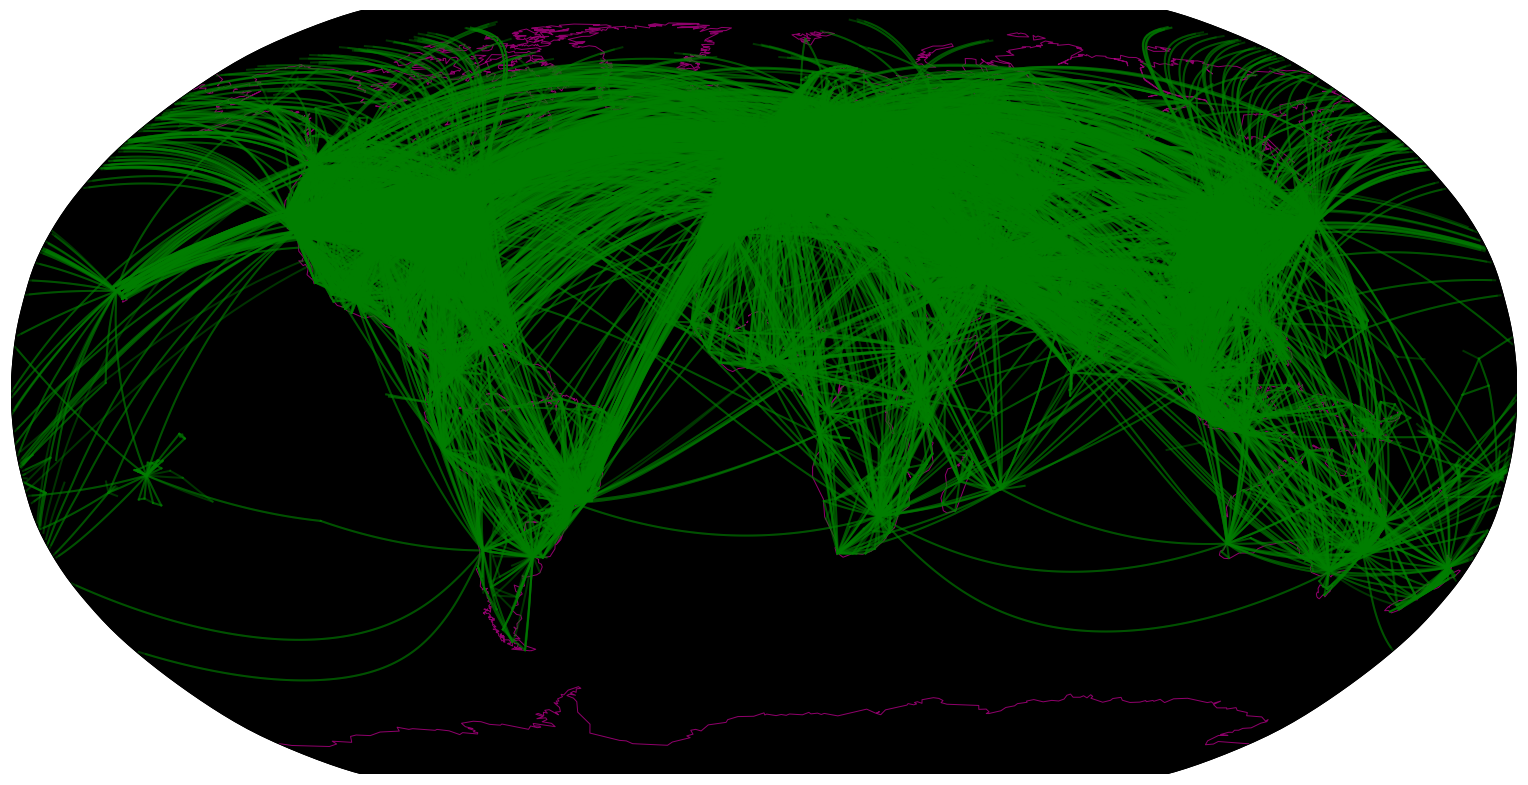

In [82]:
#routes_hel = routes[routes["from"] == "HEL"]
#neigh_hel = nx.neighbors(G1,"HEL")
#plot_map(routes_hel)
#routes_hel2 = routes[routes["from"].isin(list(neigh_hel))]
#plot_map(routes_hel2)
plot_map(routes[routes["from"].isin(list(n3_hel))])

In [19]:
ff = nx.single_source_shortest_path_length(G1, "HEL")
cumulative_counts = []
for n in range(8):
    cumulative_counts.append(np.sum(np.array(list(ff.values())) <= n))
hel_mean = np.mean(list(ff.values()))


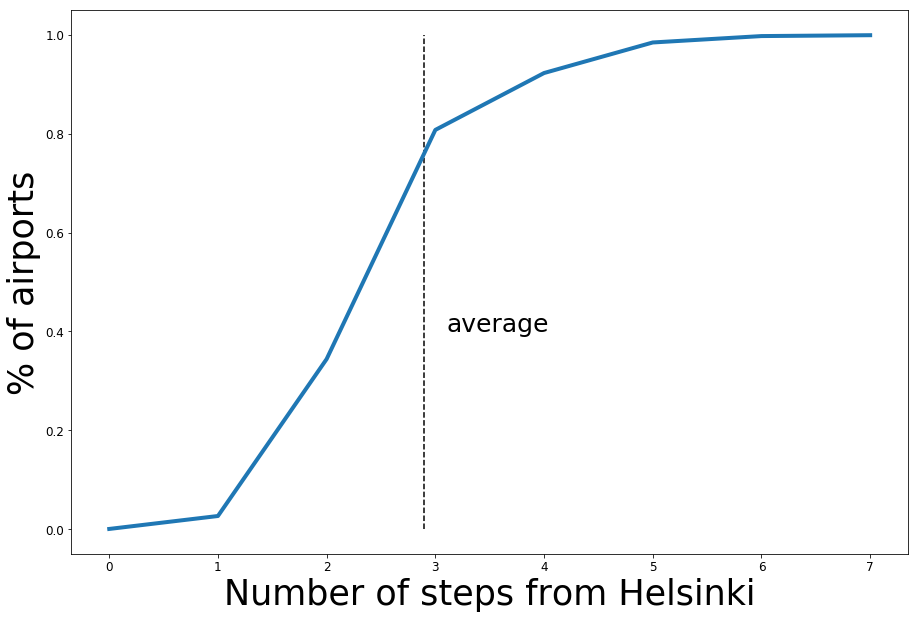

In [147]:
cumulative_counts
plt.figure(figsize= (15,10))
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 

mean = 2.9
plt.plot(range(8), np.array(cumulative_counts)/len(list(ff.values())), linewidth = 4)
plt.xlabel("Number of steps from Helsinki",fontsize = 35)
plt.ylabel("% of airports", fontsize = 35)
plt.vlines(mean, 0, 1, linestyles="dashed")
plt.text(3.1,0.4,'average', fontsize = 25)
plt.show()

In [146]:
cumulative_counts
plt.figure(figsize= (15,10))
plt.rc() 
plt.rc() 



degree_sequence = sorted([d for n, d in G1.degree()], reverse=True)
counts = []
for k in range(248): 
    counts.append(1-sum(np.array(degree_sequence) <= k) / len(degree_sequence))
plt.loglog(range(248), counts)
plt.xlabel("k", fontsize = 30)
plt.ylabel("P(d > k)", fontsize = 30)


TypeError: rc() missing 1 required positional argument: 'group'

In [85]:
import itertools
k = 4
comp = nx.algorithms.community.girvan_newman(G1)
limited = itertools.takewhile(lambda c: len(c) <= k, comp)
for communities in limited:
    print(tuple(sorted(c) for c in communities)) 

(['AAE', 'AAL', 'AAN', 'AAQ', 'AAR', 'AAT', 'AAX', 'AAY', 'ABA', 'ABB', 'ABD', 'ABE', 'ABI', 'ABJ', 'ABL', 'ABM', 'ABQ', 'ABR', 'ABS', 'ABT', 'ABV', 'ABX', 'ABY', 'ABZ', 'ACA', 'ACC', 'ACE', 'ACH', 'ACI', 'ACK', 'ACR', 'ACT', 'ACU', 'ACV', 'ACX', 'ACY', 'ACZ', 'ADA', 'ADB', 'ADD', 'ADE', 'ADF', 'ADK', 'ADL', 'ADQ', 'ADU', 'ADZ', 'AEB', 'AEP', 'AER', 'AES', 'AET', 'AEX', 'AFA', 'AFL', 'AFZ', 'AGA', 'AGB', 'AGF', 'AGH', 'AGN', 'AGP', 'AGR', 'AGS', 'AGT', 'AGU', 'AGX', 'AHB', 'AHE', 'AHN', 'AHO', 'AHU', 'AIA', 'AIN', 'AIT', 'AIU', 'AJA', 'AJF', 'AJI', 'AJL', 'AJR', 'AJU', 'AKF', 'AKI', 'AKJ', 'AKK', 'AKL', 'AKN', 'AKP', 'AKU', 'AKV', 'AKX', 'AKY', 'ALA', 'ALB', 'ALC', 'ALF', 'ALG', 'ALH', 'ALO', 'ALS', 'ALW', 'AMA', 'AMD', 'AMH', 'AMM', 'AMQ', 'AMS', 'ANC', 'ANF', 'ANG', 'ANI', 'ANM', 'ANR', 'ANS', 'ANU', 'ANV', 'ANX', 'AOE', 'AOG', 'AOI', 'AOJ', 'AOK', 'AOO', 'AOR', 'AOS', 'APF', 'APL', 'APN', 'APO', 'APW', 'AQA', 'AQG', 'AQI', 'AQJ', 'AQP', 'ARC', 'ARH', 'ARI', 'ARK', 'ARM', 'ARN', 'ART

(['AAE', 'AAL', 'AAN', 'AAQ', 'AAR', 'AAT', 'AAX', 'AAY', 'ABA', 'ABB', 'ABD', 'ABE', 'ABI', 'ABJ', 'ABL', 'ABM', 'ABQ', 'ABR', 'ABS', 'ABT', 'ABV', 'ABX', 'ABY', 'ABZ', 'ACA', 'ACC', 'ACE', 'ACH', 'ACI', 'ACK', 'ACR', 'ACT', 'ACU', 'ACV', 'ACX', 'ACY', 'ACZ', 'ADA', 'ADB', 'ADD', 'ADE', 'ADF', 'ADK', 'ADL', 'ADQ', 'ADU', 'ADZ', 'AEB', 'AEP', 'AER', 'AES', 'AET', 'AEX', 'AFA', 'AFL', 'AFZ', 'AGA', 'AGB', 'AGF', 'AGH', 'AGN', 'AGP', 'AGR', 'AGS', 'AGT', 'AGU', 'AGX', 'AHB', 'AHE', 'AHN', 'AHO', 'AHU', 'AIA', 'AIN', 'AIT', 'AIU', 'AJA', 'AJF', 'AJI', 'AJL', 'AJR', 'AJU', 'AKF', 'AKJ', 'AKK', 'AKL', 'AKN', 'AKP', 'AKU', 'AKV', 'AKX', 'AKY', 'ALA', 'ALB', 'ALC', 'ALF', 'ALG', 'ALH', 'ALO', 'ALS', 'ALW', 'AMA', 'AMD', 'AMH', 'AMM', 'AMQ', 'AMS', 'ANC', 'ANF', 'ANG', 'ANM', 'ANR', 'ANS', 'ANU', 'ANX', 'AOE', 'AOG', 'AOI', 'AOJ', 'AOK', 'AOO', 'AOR', 'AOS', 'APF', 'APL', 'APN', 'APO', 'APW', 'AQA', 'AQG', 'AQI', 'AQJ', 'AQP', 'ARC', 'ARH', 'ARI', 'ARK', 'ARM', 'ARN', 'ART', 'ARU', 'ARW', 'ASB

(['AAE', 'AAL', 'AAN', 'AAQ', 'AAR', 'AAT', 'AAX', 'AAY', 'ABA', 'ABB', 'ABD', 'ABE', 'ABI', 'ABJ', 'ABM', 'ABQ', 'ABR', 'ABS', 'ABT', 'ABV', 'ABX', 'ABY', 'ABZ', 'ACA', 'ACC', 'ACE', 'ACH', 'ACI', 'ACK', 'ACR', 'ACT', 'ACU', 'ACV', 'ACX', 'ACY', 'ACZ', 'ADA', 'ADB', 'ADD', 'ADE', 'ADF', 'ADL', 'ADU', 'ADZ', 'AEB', 'AEP', 'AER', 'AES', 'AEX', 'AFA', 'AFL', 'AFZ', 'AGA', 'AGB', 'AGF', 'AGH', 'AGP', 'AGR', 'AGS', 'AGT', 'AGU', 'AGX', 'AHB', 'AHE', 'AHN', 'AHO', 'AHU', 'AIA', 'AIT', 'AIU', 'AJA', 'AJF', 'AJI', 'AJL', 'AJR', 'AJU', 'AKF', 'AKJ', 'AKL', 'AKU', 'AKV', 'AKX', 'AKY', 'ALA', 'ALB', 'ALC', 'ALF', 'ALG', 'ALH', 'ALO', 'ALS', 'ALW', 'AMA', 'AMD', 'AMH', 'AMM', 'AMQ', 'AMS', 'ANF', 'ANG', 'ANM', 'ANR', 'ANS', 'ANU', 'ANX', 'AOE', 'AOG', 'AOI', 'AOJ', 'AOK', 'AOO', 'AOR', 'APF', 'APL', 'APN', 'APO', 'APW', 'AQA', 'AQG', 'AQI', 'AQJ', 'AQP', 'ARH', 'ARI', 'ARK', 'ARM', 'ARN', 'ART', 'ARU', 'ARW', 'ASB', 'ASE', 'ASF', 'ASJ', 'ASM', 'ASO', 'ASP', 'ASR', 'ASU', 'ASV', 'ASW', 'ATA', 'ATC

In [92]:
k = 15
comp = nx.algorithms.community.girvan_newman(G1)
limited = itertools.takewhile(lambda c: len(c) <= k, comp)

parts = []
for communities in limited:
    parts.append(tuple(sorted(c) for c in communities))
    print(parts)

[(['AAE', 'AAL', 'AAN', 'AAQ', 'AAR', 'AAT', 'AAX', 'AAY', 'ABA', 'ABB', 'ABD', 'ABE', 'ABI', 'ABJ', 'ABL', 'ABM', 'ABQ', 'ABR', 'ABS', 'ABT', 'ABV', 'ABX', 'ABY', 'ABZ', 'ACA', 'ACC', 'ACE', 'ACH', 'ACI', 'ACK', 'ACR', 'ACT', 'ACU', 'ACV', 'ACX', 'ACY', 'ACZ', 'ADA', 'ADB', 'ADD', 'ADE', 'ADF', 'ADK', 'ADL', 'ADQ', 'ADU', 'ADZ', 'AEB', 'AEP', 'AER', 'AES', 'AET', 'AEX', 'AFA', 'AFL', 'AFZ', 'AGA', 'AGB', 'AGF', 'AGH', 'AGN', 'AGP', 'AGR', 'AGS', 'AGT', 'AGU', 'AGX', 'AHB', 'AHE', 'AHN', 'AHO', 'AHU', 'AIA', 'AIN', 'AIT', 'AIU', 'AJA', 'AJF', 'AJI', 'AJL', 'AJR', 'AJU', 'AKF', 'AKI', 'AKJ', 'AKK', 'AKL', 'AKN', 'AKP', 'AKU', 'AKV', 'AKX', 'AKY', 'ALA', 'ALB', 'ALC', 'ALF', 'ALG', 'ALH', 'ALO', 'ALS', 'ALW', 'AMA', 'AMD', 'AMH', 'AMM', 'AMQ', 'AMS', 'ANC', 'ANF', 'ANG', 'ANI', 'ANM', 'ANR', 'ANS', 'ANU', 'ANV', 'ANX', 'AOE', 'AOG', 'AOI', 'AOJ', 'AOK', 'AOO', 'AOR', 'AOS', 'APF', 'APL', 'APN', 'APO', 'APW', 'AQA', 'AQG', 'AQI', 'AQJ', 'AQP', 'ARC', 'ARH', 'ARI', 'ARK', 'ARM', 'ARN', 'AR

[(['AAE', 'AAL', 'AAN', 'AAQ', 'AAR', 'AAT', 'AAX', 'AAY', 'ABA', 'ABB', 'ABD', 'ABE', 'ABI', 'ABJ', 'ABL', 'ABM', 'ABQ', 'ABR', 'ABS', 'ABT', 'ABV', 'ABX', 'ABY', 'ABZ', 'ACA', 'ACC', 'ACE', 'ACH', 'ACI', 'ACK', 'ACR', 'ACT', 'ACU', 'ACV', 'ACX', 'ACY', 'ACZ', 'ADA', 'ADB', 'ADD', 'ADE', 'ADF', 'ADK', 'ADL', 'ADQ', 'ADU', 'ADZ', 'AEB', 'AEP', 'AER', 'AES', 'AET', 'AEX', 'AFA', 'AFL', 'AFZ', 'AGA', 'AGB', 'AGF', 'AGH', 'AGN', 'AGP', 'AGR', 'AGS', 'AGT', 'AGU', 'AGX', 'AHB', 'AHE', 'AHN', 'AHO', 'AHU', 'AIA', 'AIN', 'AIT', 'AIU', 'AJA', 'AJF', 'AJI', 'AJL', 'AJR', 'AJU', 'AKF', 'AKI', 'AKJ', 'AKK', 'AKL', 'AKN', 'AKP', 'AKU', 'AKV', 'AKX', 'AKY', 'ALA', 'ALB', 'ALC', 'ALF', 'ALG', 'ALH', 'ALO', 'ALS', 'ALW', 'AMA', 'AMD', 'AMH', 'AMM', 'AMQ', 'AMS', 'ANC', 'ANF', 'ANG', 'ANI', 'ANM', 'ANR', 'ANS', 'ANU', 'ANV', 'ANX', 'AOE', 'AOG', 'AOI', 'AOJ', 'AOK', 'AOO', 'AOR', 'AOS', 'APF', 'APL', 'APN', 'APO', 'APW', 'AQA', 'AQG', 'AQI', 'AQJ', 'AQP', 'ARC', 'ARH', 'ARI', 'ARK', 'ARM', 'ARN', 'AR

[(['AAE', 'AAL', 'AAN', 'AAQ', 'AAR', 'AAT', 'AAX', 'AAY', 'ABA', 'ABB', 'ABD', 'ABE', 'ABI', 'ABJ', 'ABL', 'ABM', 'ABQ', 'ABR', 'ABS', 'ABT', 'ABV', 'ABX', 'ABY', 'ABZ', 'ACA', 'ACC', 'ACE', 'ACH', 'ACI', 'ACK', 'ACR', 'ACT', 'ACU', 'ACV', 'ACX', 'ACY', 'ACZ', 'ADA', 'ADB', 'ADD', 'ADE', 'ADF', 'ADK', 'ADL', 'ADQ', 'ADU', 'ADZ', 'AEB', 'AEP', 'AER', 'AES', 'AET', 'AEX', 'AFA', 'AFL', 'AFZ', 'AGA', 'AGB', 'AGF', 'AGH', 'AGN', 'AGP', 'AGR', 'AGS', 'AGT', 'AGU', 'AGX', 'AHB', 'AHE', 'AHN', 'AHO', 'AHU', 'AIA', 'AIN', 'AIT', 'AIU', 'AJA', 'AJF', 'AJI', 'AJL', 'AJR', 'AJU', 'AKF', 'AKI', 'AKJ', 'AKK', 'AKL', 'AKN', 'AKP', 'AKU', 'AKV', 'AKX', 'AKY', 'ALA', 'ALB', 'ALC', 'ALF', 'ALG', 'ALH', 'ALO', 'ALS', 'ALW', 'AMA', 'AMD', 'AMH', 'AMM', 'AMQ', 'AMS', 'ANC', 'ANF', 'ANG', 'ANI', 'ANM', 'ANR', 'ANS', 'ANU', 'ANV', 'ANX', 'AOE', 'AOG', 'AOI', 'AOJ', 'AOK', 'AOO', 'AOR', 'AOS', 'APF', 'APL', 'APN', 'APO', 'APW', 'AQA', 'AQG', 'AQI', 'AQJ', 'AQP', 'ARC', 'ARH', 'ARI', 'ARK', 'ARM', 'ARN', 'AR

[(['AAE', 'AAL', 'AAN', 'AAQ', 'AAR', 'AAT', 'AAX', 'AAY', 'ABA', 'ABB', 'ABD', 'ABE', 'ABI', 'ABJ', 'ABL', 'ABM', 'ABQ', 'ABR', 'ABS', 'ABT', 'ABV', 'ABX', 'ABY', 'ABZ', 'ACA', 'ACC', 'ACE', 'ACH', 'ACI', 'ACK', 'ACR', 'ACT', 'ACU', 'ACV', 'ACX', 'ACY', 'ACZ', 'ADA', 'ADB', 'ADD', 'ADE', 'ADF', 'ADK', 'ADL', 'ADQ', 'ADU', 'ADZ', 'AEB', 'AEP', 'AER', 'AES', 'AET', 'AEX', 'AFA', 'AFL', 'AFZ', 'AGA', 'AGB', 'AGF', 'AGH', 'AGN', 'AGP', 'AGR', 'AGS', 'AGT', 'AGU', 'AGX', 'AHB', 'AHE', 'AHN', 'AHO', 'AHU', 'AIA', 'AIN', 'AIT', 'AIU', 'AJA', 'AJF', 'AJI', 'AJL', 'AJR', 'AJU', 'AKF', 'AKI', 'AKJ', 'AKK', 'AKL', 'AKN', 'AKP', 'AKU', 'AKV', 'AKX', 'AKY', 'ALA', 'ALB', 'ALC', 'ALF', 'ALG', 'ALH', 'ALO', 'ALS', 'ALW', 'AMA', 'AMD', 'AMH', 'AMM', 'AMQ', 'AMS', 'ANC', 'ANF', 'ANG', 'ANI', 'ANM', 'ANR', 'ANS', 'ANU', 'ANV', 'ANX', 'AOE', 'AOG', 'AOI', 'AOJ', 'AOK', 'AOO', 'AOR', 'AOS', 'APF', 'APL', 'APN', 'APO', 'APW', 'AQA', 'AQG', 'AQI', 'AQJ', 'AQP', 'ARC', 'ARH', 'ARI', 'ARK', 'ARM', 'ARN', 'AR

[(['AAE', 'AAL', 'AAN', 'AAQ', 'AAR', 'AAT', 'AAX', 'AAY', 'ABA', 'ABB', 'ABD', 'ABE', 'ABI', 'ABJ', 'ABL', 'ABM', 'ABQ', 'ABR', 'ABS', 'ABT', 'ABV', 'ABX', 'ABY', 'ABZ', 'ACA', 'ACC', 'ACE', 'ACH', 'ACI', 'ACK', 'ACR', 'ACT', 'ACU', 'ACV', 'ACX', 'ACY', 'ACZ', 'ADA', 'ADB', 'ADD', 'ADE', 'ADF', 'ADK', 'ADL', 'ADQ', 'ADU', 'ADZ', 'AEB', 'AEP', 'AER', 'AES', 'AET', 'AEX', 'AFA', 'AFL', 'AFZ', 'AGA', 'AGB', 'AGF', 'AGH', 'AGN', 'AGP', 'AGR', 'AGS', 'AGT', 'AGU', 'AGX', 'AHB', 'AHE', 'AHN', 'AHO', 'AHU', 'AIA', 'AIN', 'AIT', 'AIU', 'AJA', 'AJF', 'AJI', 'AJL', 'AJR', 'AJU', 'AKF', 'AKI', 'AKJ', 'AKK', 'AKL', 'AKN', 'AKP', 'AKU', 'AKV', 'AKX', 'AKY', 'ALA', 'ALB', 'ALC', 'ALF', 'ALG', 'ALH', 'ALO', 'ALS', 'ALW', 'AMA', 'AMD', 'AMH', 'AMM', 'AMQ', 'AMS', 'ANC', 'ANF', 'ANG', 'ANI', 'ANM', 'ANR', 'ANS', 'ANU', 'ANV', 'ANX', 'AOE', 'AOG', 'AOI', 'AOJ', 'AOK', 'AOO', 'AOR', 'AOS', 'APF', 'APL', 'APN', 'APO', 'APW', 'AQA', 'AQG', 'AQI', 'AQJ', 'AQP', 'ARC', 'ARH', 'ARI', 'ARK', 'ARM', 'ARN', 'AR

[(['AAE', 'AAL', 'AAN', 'AAQ', 'AAR', 'AAT', 'AAX', 'AAY', 'ABA', 'ABB', 'ABD', 'ABE', 'ABI', 'ABJ', 'ABL', 'ABM', 'ABQ', 'ABR', 'ABS', 'ABT', 'ABV', 'ABX', 'ABY', 'ABZ', 'ACA', 'ACC', 'ACE', 'ACH', 'ACI', 'ACK', 'ACR', 'ACT', 'ACU', 'ACV', 'ACX', 'ACY', 'ACZ', 'ADA', 'ADB', 'ADD', 'ADE', 'ADF', 'ADK', 'ADL', 'ADQ', 'ADU', 'ADZ', 'AEB', 'AEP', 'AER', 'AES', 'AET', 'AEX', 'AFA', 'AFL', 'AFZ', 'AGA', 'AGB', 'AGF', 'AGH', 'AGN', 'AGP', 'AGR', 'AGS', 'AGT', 'AGU', 'AGX', 'AHB', 'AHE', 'AHN', 'AHO', 'AHU', 'AIA', 'AIN', 'AIT', 'AIU', 'AJA', 'AJF', 'AJI', 'AJL', 'AJR', 'AJU', 'AKF', 'AKI', 'AKJ', 'AKK', 'AKL', 'AKN', 'AKP', 'AKU', 'AKV', 'AKX', 'AKY', 'ALA', 'ALB', 'ALC', 'ALF', 'ALG', 'ALH', 'ALO', 'ALS', 'ALW', 'AMA', 'AMD', 'AMH', 'AMM', 'AMQ', 'AMS', 'ANC', 'ANF', 'ANG', 'ANI', 'ANM', 'ANR', 'ANS', 'ANU', 'ANV', 'ANX', 'AOE', 'AOG', 'AOI', 'AOJ', 'AOK', 'AOO', 'AOR', 'AOS', 'APF', 'APL', 'APN', 'APO', 'APW', 'AQA', 'AQG', 'AQI', 'AQJ', 'AQP', 'ARC', 'ARH', 'ARI', 'ARK', 'ARM', 'ARN', 'AR

[(['AAE', 'AAL', 'AAN', 'AAQ', 'AAR', 'AAT', 'AAX', 'AAY', 'ABA', 'ABB', 'ABD', 'ABE', 'ABI', 'ABJ', 'ABL', 'ABM', 'ABQ', 'ABR', 'ABS', 'ABT', 'ABV', 'ABX', 'ABY', 'ABZ', 'ACA', 'ACC', 'ACE', 'ACH', 'ACI', 'ACK', 'ACR', 'ACT', 'ACU', 'ACV', 'ACX', 'ACY', 'ACZ', 'ADA', 'ADB', 'ADD', 'ADE', 'ADF', 'ADK', 'ADL', 'ADQ', 'ADU', 'ADZ', 'AEB', 'AEP', 'AER', 'AES', 'AET', 'AEX', 'AFA', 'AFL', 'AFZ', 'AGA', 'AGB', 'AGF', 'AGH', 'AGN', 'AGP', 'AGR', 'AGS', 'AGT', 'AGU', 'AGX', 'AHB', 'AHE', 'AHN', 'AHO', 'AHU', 'AIA', 'AIN', 'AIT', 'AIU', 'AJA', 'AJF', 'AJI', 'AJL', 'AJR', 'AJU', 'AKF', 'AKI', 'AKJ', 'AKK', 'AKL', 'AKN', 'AKP', 'AKU', 'AKV', 'AKX', 'AKY', 'ALA', 'ALB', 'ALC', 'ALF', 'ALG', 'ALH', 'ALO', 'ALS', 'ALW', 'AMA', 'AMD', 'AMH', 'AMM', 'AMQ', 'AMS', 'ANC', 'ANF', 'ANG', 'ANI', 'ANM', 'ANR', 'ANS', 'ANU', 'ANV', 'ANX', 'AOE', 'AOG', 'AOI', 'AOJ', 'AOK', 'AOO', 'AOR', 'AOS', 'APF', 'APL', 'APN', 'APO', 'APW', 'AQA', 'AQG', 'AQI', 'AQJ', 'AQP', 'ARC', 'ARH', 'ARI', 'ARK', 'ARM', 'ARN', 'AR

[(['AAE', 'AAL', 'AAN', 'AAQ', 'AAR', 'AAT', 'AAX', 'AAY', 'ABA', 'ABB', 'ABD', 'ABE', 'ABI', 'ABJ', 'ABL', 'ABM', 'ABQ', 'ABR', 'ABS', 'ABT', 'ABV', 'ABX', 'ABY', 'ABZ', 'ACA', 'ACC', 'ACE', 'ACH', 'ACI', 'ACK', 'ACR', 'ACT', 'ACU', 'ACV', 'ACX', 'ACY', 'ACZ', 'ADA', 'ADB', 'ADD', 'ADE', 'ADF', 'ADK', 'ADL', 'ADQ', 'ADU', 'ADZ', 'AEB', 'AEP', 'AER', 'AES', 'AET', 'AEX', 'AFA', 'AFL', 'AFZ', 'AGA', 'AGB', 'AGF', 'AGH', 'AGN', 'AGP', 'AGR', 'AGS', 'AGT', 'AGU', 'AGX', 'AHB', 'AHE', 'AHN', 'AHO', 'AHU', 'AIA', 'AIN', 'AIT', 'AIU', 'AJA', 'AJF', 'AJI', 'AJL', 'AJR', 'AJU', 'AKF', 'AKI', 'AKJ', 'AKK', 'AKL', 'AKN', 'AKP', 'AKU', 'AKV', 'AKX', 'AKY', 'ALA', 'ALB', 'ALC', 'ALF', 'ALG', 'ALH', 'ALO', 'ALS', 'ALW', 'AMA', 'AMD', 'AMH', 'AMM', 'AMQ', 'AMS', 'ANC', 'ANF', 'ANG', 'ANI', 'ANM', 'ANR', 'ANS', 'ANU', 'ANV', 'ANX', 'AOE', 'AOG', 'AOI', 'AOJ', 'AOK', 'AOO', 'AOR', 'AOS', 'APF', 'APL', 'APN', 'APO', 'APW', 'AQA', 'AQG', 'AQI', 'AQJ', 'AQP', 'ARC', 'ARH', 'ARI', 'ARK', 'ARM', 'ARN', 'AR

[(['AAE', 'AAL', 'AAN', 'AAQ', 'AAR', 'AAT', 'AAX', 'AAY', 'ABA', 'ABB', 'ABD', 'ABE', 'ABI', 'ABJ', 'ABL', 'ABM', 'ABQ', 'ABR', 'ABS', 'ABT', 'ABV', 'ABX', 'ABY', 'ABZ', 'ACA', 'ACC', 'ACE', 'ACH', 'ACI', 'ACK', 'ACR', 'ACT', 'ACU', 'ACV', 'ACX', 'ACY', 'ACZ', 'ADA', 'ADB', 'ADD', 'ADE', 'ADF', 'ADK', 'ADL', 'ADQ', 'ADU', 'ADZ', 'AEB', 'AEP', 'AER', 'AES', 'AET', 'AEX', 'AFA', 'AFL', 'AFZ', 'AGA', 'AGB', 'AGF', 'AGH', 'AGN', 'AGP', 'AGR', 'AGS', 'AGT', 'AGU', 'AGX', 'AHB', 'AHE', 'AHN', 'AHO', 'AHU', 'AIA', 'AIN', 'AIT', 'AIU', 'AJA', 'AJF', 'AJI', 'AJL', 'AJR', 'AJU', 'AKF', 'AKI', 'AKJ', 'AKK', 'AKL', 'AKN', 'AKP', 'AKU', 'AKV', 'AKX', 'AKY', 'ALA', 'ALB', 'ALC', 'ALF', 'ALG', 'ALH', 'ALO', 'ALS', 'ALW', 'AMA', 'AMD', 'AMH', 'AMM', 'AMQ', 'AMS', 'ANC', 'ANF', 'ANG', 'ANI', 'ANM', 'ANR', 'ANS', 'ANU', 'ANV', 'ANX', 'AOE', 'AOG', 'AOI', 'AOJ', 'AOK', 'AOO', 'AOR', 'AOS', 'APF', 'APL', 'APN', 'APO', 'APW', 'AQA', 'AQG', 'AQI', 'AQJ', 'AQP', 'ARC', 'ARH', 'ARI', 'ARK', 'ARM', 'ARN', 'AR

[(['AAE', 'AAL', 'AAN', 'AAQ', 'AAR', 'AAT', 'AAX', 'AAY', 'ABA', 'ABB', 'ABD', 'ABE', 'ABI', 'ABJ', 'ABL', 'ABM', 'ABQ', 'ABR', 'ABS', 'ABT', 'ABV', 'ABX', 'ABY', 'ABZ', 'ACA', 'ACC', 'ACE', 'ACH', 'ACI', 'ACK', 'ACR', 'ACT', 'ACU', 'ACV', 'ACX', 'ACY', 'ACZ', 'ADA', 'ADB', 'ADD', 'ADE', 'ADF', 'ADK', 'ADL', 'ADQ', 'ADU', 'ADZ', 'AEB', 'AEP', 'AER', 'AES', 'AET', 'AEX', 'AFA', 'AFL', 'AFZ', 'AGA', 'AGB', 'AGF', 'AGH', 'AGN', 'AGP', 'AGR', 'AGS', 'AGT', 'AGU', 'AGX', 'AHB', 'AHE', 'AHN', 'AHO', 'AHU', 'AIA', 'AIN', 'AIT', 'AIU', 'AJA', 'AJF', 'AJI', 'AJL', 'AJR', 'AJU', 'AKF', 'AKI', 'AKJ', 'AKK', 'AKL', 'AKN', 'AKP', 'AKU', 'AKV', 'AKX', 'AKY', 'ALA', 'ALB', 'ALC', 'ALF', 'ALG', 'ALH', 'ALO', 'ALS', 'ALW', 'AMA', 'AMD', 'AMH', 'AMM', 'AMQ', 'AMS', 'ANC', 'ANF', 'ANG', 'ANI', 'ANM', 'ANR', 'ANS', 'ANU', 'ANV', 'ANX', 'AOE', 'AOG', 'AOI', 'AOJ', 'AOK', 'AOO', 'AOR', 'AOS', 'APF', 'APL', 'APN', 'APO', 'APW', 'AQA', 'AQG', 'AQI', 'AQJ', 'AQP', 'ARC', 'ARH', 'ARI', 'ARK', 'ARM', 'ARN', 'AR

[(['AAE', 'AAL', 'AAN', 'AAQ', 'AAR', 'AAT', 'AAX', 'AAY', 'ABA', 'ABB', 'ABD', 'ABE', 'ABI', 'ABJ', 'ABL', 'ABM', 'ABQ', 'ABR', 'ABS', 'ABT', 'ABV', 'ABX', 'ABY', 'ABZ', 'ACA', 'ACC', 'ACE', 'ACH', 'ACI', 'ACK', 'ACR', 'ACT', 'ACU', 'ACV', 'ACX', 'ACY', 'ACZ', 'ADA', 'ADB', 'ADD', 'ADE', 'ADF', 'ADK', 'ADL', 'ADQ', 'ADU', 'ADZ', 'AEB', 'AEP', 'AER', 'AES', 'AET', 'AEX', 'AFA', 'AFL', 'AFZ', 'AGA', 'AGB', 'AGF', 'AGH', 'AGN', 'AGP', 'AGR', 'AGS', 'AGT', 'AGU', 'AGX', 'AHB', 'AHE', 'AHN', 'AHO', 'AHU', 'AIA', 'AIN', 'AIT', 'AIU', 'AJA', 'AJF', 'AJI', 'AJL', 'AJR', 'AJU', 'AKF', 'AKI', 'AKJ', 'AKK', 'AKL', 'AKN', 'AKP', 'AKU', 'AKV', 'AKX', 'AKY', 'ALA', 'ALB', 'ALC', 'ALF', 'ALG', 'ALH', 'ALO', 'ALS', 'ALW', 'AMA', 'AMD', 'AMH', 'AMM', 'AMQ', 'AMS', 'ANC', 'ANF', 'ANG', 'ANI', 'ANM', 'ANR', 'ANS', 'ANU', 'ANV', 'ANX', 'AOE', 'AOG', 'AOI', 'AOJ', 'AOK', 'AOO', 'AOR', 'AOS', 'APF', 'APL', 'APN', 'APO', 'APW', 'AQA', 'AQG', 'AQI', 'AQJ', 'AQP', 'ARC', 'ARH', 'ARI', 'ARK', 'ARM', 'ARN', 'AR

[(['AAE', 'AAL', 'AAN', 'AAQ', 'AAR', 'AAT', 'AAX', 'AAY', 'ABA', 'ABB', 'ABD', 'ABE', 'ABI', 'ABJ', 'ABL', 'ABM', 'ABQ', 'ABR', 'ABS', 'ABT', 'ABV', 'ABX', 'ABY', 'ABZ', 'ACA', 'ACC', 'ACE', 'ACH', 'ACI', 'ACK', 'ACR', 'ACT', 'ACU', 'ACV', 'ACX', 'ACY', 'ACZ', 'ADA', 'ADB', 'ADD', 'ADE', 'ADF', 'ADK', 'ADL', 'ADQ', 'ADU', 'ADZ', 'AEB', 'AEP', 'AER', 'AES', 'AET', 'AEX', 'AFA', 'AFL', 'AFZ', 'AGA', 'AGB', 'AGF', 'AGH', 'AGN', 'AGP', 'AGR', 'AGS', 'AGT', 'AGU', 'AGX', 'AHB', 'AHE', 'AHN', 'AHO', 'AHU', 'AIA', 'AIN', 'AIT', 'AIU', 'AJA', 'AJF', 'AJI', 'AJL', 'AJR', 'AJU', 'AKF', 'AKI', 'AKJ', 'AKK', 'AKL', 'AKN', 'AKP', 'AKU', 'AKV', 'AKX', 'AKY', 'ALA', 'ALB', 'ALC', 'ALF', 'ALG', 'ALH', 'ALO', 'ALS', 'ALW', 'AMA', 'AMD', 'AMH', 'AMM', 'AMQ', 'AMS', 'ANC', 'ANF', 'ANG', 'ANI', 'ANM', 'ANR', 'ANS', 'ANU', 'ANV', 'ANX', 'AOE', 'AOG', 'AOI', 'AOJ', 'AOK', 'AOO', 'AOR', 'AOS', 'APF', 'APL', 'APN', 'APO', 'APW', 'AQA', 'AQG', 'AQI', 'AQJ', 'AQP', 'ARC', 'ARH', 'ARI', 'ARK', 'ARM', 'ARN', 'AR

[(['AAE', 'AAL', 'AAN', 'AAQ', 'AAR', 'AAT', 'AAX', 'AAY', 'ABA', 'ABB', 'ABD', 'ABE', 'ABI', 'ABJ', 'ABL', 'ABM', 'ABQ', 'ABR', 'ABS', 'ABT', 'ABV', 'ABX', 'ABY', 'ABZ', 'ACA', 'ACC', 'ACE', 'ACH', 'ACI', 'ACK', 'ACR', 'ACT', 'ACU', 'ACV', 'ACX', 'ACY', 'ACZ', 'ADA', 'ADB', 'ADD', 'ADE', 'ADF', 'ADK', 'ADL', 'ADQ', 'ADU', 'ADZ', 'AEB', 'AEP', 'AER', 'AES', 'AET', 'AEX', 'AFA', 'AFL', 'AFZ', 'AGA', 'AGB', 'AGF', 'AGH', 'AGN', 'AGP', 'AGR', 'AGS', 'AGT', 'AGU', 'AGX', 'AHB', 'AHE', 'AHN', 'AHO', 'AHU', 'AIA', 'AIN', 'AIT', 'AIU', 'AJA', 'AJF', 'AJI', 'AJL', 'AJR', 'AJU', 'AKF', 'AKI', 'AKJ', 'AKK', 'AKL', 'AKN', 'AKP', 'AKU', 'AKV', 'AKX', 'AKY', 'ALA', 'ALB', 'ALC', 'ALF', 'ALG', 'ALH', 'ALO', 'ALS', 'ALW', 'AMA', 'AMD', 'AMH', 'AMM', 'AMQ', 'AMS', 'ANC', 'ANF', 'ANG', 'ANI', 'ANM', 'ANR', 'ANS', 'ANU', 'ANV', 'ANX', 'AOE', 'AOG', 'AOI', 'AOJ', 'AOK', 'AOO', 'AOR', 'AOS', 'APF', 'APL', 'APN', 'APO', 'APW', 'AQA', 'AQG', 'AQI', 'AQJ', 'AQP', 'ARC', 'ARH', 'ARI', 'ARK', 'ARM', 'ARN', 'AR

[(['AAE', 'AAL', 'AAN', 'AAQ', 'AAR', 'AAT', 'AAX', 'AAY', 'ABA', 'ABB', 'ABD', 'ABE', 'ABI', 'ABJ', 'ABL', 'ABM', 'ABQ', 'ABR', 'ABS', 'ABT', 'ABV', 'ABX', 'ABY', 'ABZ', 'ACA', 'ACC', 'ACE', 'ACH', 'ACI', 'ACK', 'ACR', 'ACT', 'ACU', 'ACV', 'ACX', 'ACY', 'ACZ', 'ADA', 'ADB', 'ADD', 'ADE', 'ADF', 'ADK', 'ADL', 'ADQ', 'ADU', 'ADZ', 'AEB', 'AEP', 'AER', 'AES', 'AET', 'AEX', 'AFA', 'AFL', 'AFZ', 'AGA', 'AGB', 'AGF', 'AGH', 'AGN', 'AGP', 'AGR', 'AGS', 'AGT', 'AGU', 'AGX', 'AHB', 'AHE', 'AHN', 'AHO', 'AHU', 'AIA', 'AIN', 'AIT', 'AIU', 'AJA', 'AJF', 'AJI', 'AJL', 'AJR', 'AJU', 'AKF', 'AKI', 'AKJ', 'AKK', 'AKL', 'AKN', 'AKP', 'AKU', 'AKV', 'AKX', 'AKY', 'ALA', 'ALB', 'ALC', 'ALF', 'ALG', 'ALH', 'ALO', 'ALS', 'ALW', 'AMA', 'AMD', 'AMH', 'AMM', 'AMQ', 'AMS', 'ANC', 'ANF', 'ANG', 'ANI', 'ANM', 'ANR', 'ANS', 'ANU', 'ANV', 'ANX', 'AOE', 'AOG', 'AOI', 'AOJ', 'AOK', 'AOO', 'AOR', 'AOS', 'APF', 'APL', 'APN', 'APO', 'APW', 'AQA', 'AQG', 'AQI', 'AQJ', 'AQP', 'ARC', 'ARH', 'ARI', 'ARK', 'ARM', 'ARN', 'AR

In [130]:
parts[7][0]
for ix, g in enumerate(parts[7]):
    for a in g:
        if not a == "\\N":
            airports.loc[a, "group"] = ix
    

ValueError: cannot reindex from a duplicate axis

['AKI', 'ANI', 'ANV', 'ATT', 'AUK', 'BET', 'CHU', 'CKD', 'CYF', 'EEK', 'EMK', 'GNU', 'HCR', 'HPB', 'KGX', 'KKH', 'KKI', 'KLG', 'KOT', 'KPN', 'KSM', 'KUK', 'KWK', 'KWN', 'KWT', 'MCG', 'MLL', 'MOU', 'MYU', 'NIB', 'NME', 'NUP', 'OOK', 'PKA', 'PQS', 'PTU', 'RDV', 'RSH', 'SCM', 'SHX', 'SLQ', 'SRV', 'SXP', 'TCT', 'TLJ', 'TLT', 'TNK', 'TOG', 'VAK', 'WNA', 'WTL', 'WWT']


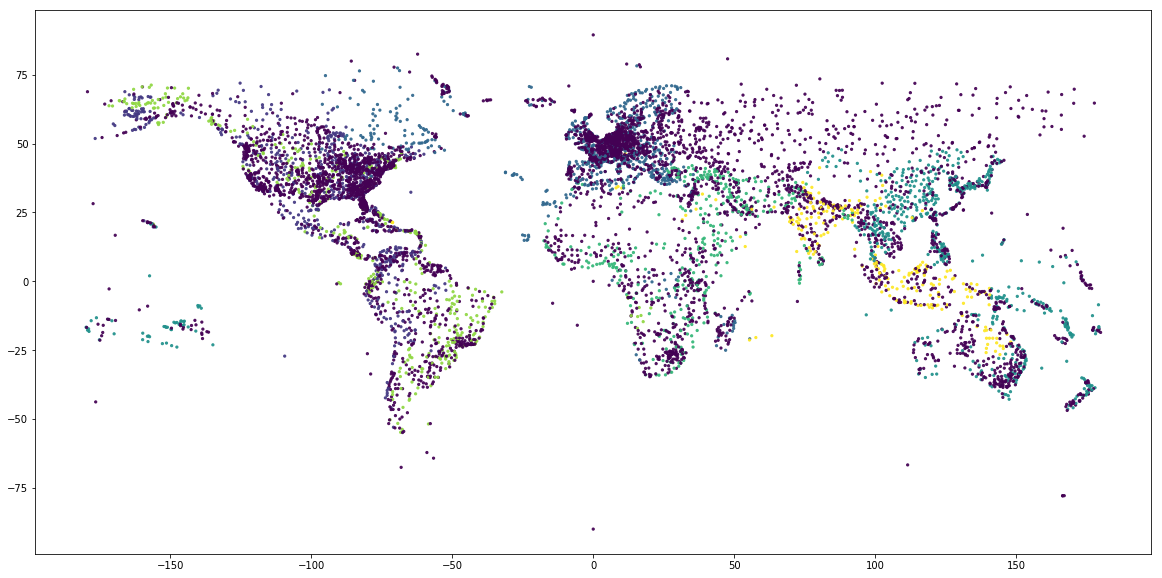

In [213]:
print(parts[7][7])

for c in range(len(ff)):
    airports.loc[airports.index.isin(ff[c]), "group"] = c
plt.figure(figsize = (20,10))
plt.scatter(airports["longitude"], airports["latitude"], c= airports["group"], s= 5, alpha =.9)

#airports.groupby("group").nunique()

In [206]:
c = list(nx.algorithms.community.asyn_fluidc(G1, 7, max_iter = 1000))
ff = c

In [109]:
routes_hel = routes[routes["from"] == "HEL"]
neigh_hel = nx.neighbors(G1,"HEL")
routes_hel2 = routes[routes["from"].isin(list(neigh_hel))]
longest_path = ['YZG',
 'YIK',
 'AKV',
 'YPX',
 'YGL',
 'YUL',
 'ZRH',
 'KEF',
 'GOH',
 'UAK',
 'JJU',
 'JNN',
 'QFN',
 'QUV']

plot_map(routes[routes["from"] == "YZG" and routes["to"] == "YIK"])
    

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [128]:
airports

airport_id                                 airport_name          city  \
iata                                                                          
GKA            1                               Goroka Airport        Goroka   
MAG            2                               Madang Airport        Madang   
HGU            3                 Mount Hagen Kagamuga Airport   Mount Hagen   
LAE            4                               Nadzab Airport        Nadzab   
POM            5  Port Moresby Jacksons International Airport  Port Moresby   
...          ...                                          ...           ...   
\N         14106                          Rogachyovo Air Base        Belaya   
\N         14107                        Ulan-Ude East Airport      Ulan Ude   
\N         14108                         Krechevitsy Air Base      Novgorod   
CPO        14109                  Desierto de Atacama Airport       Copiapo   
\N         14110                           Melitopol Air Base     Melitopol   

               country iata  icao   latitude   longitude  altitude timezone  \
iata                                                                          
GKA   Papua New Guinea  GKA  AYGA  -6.081690  145.391998      5282       10   
MAG   Papua New Guinea  MAG  AYMD  -5.207080  145.789001        20       10   
HGU   Papua New Guinea  HGU  AYMH  -5.826790  144.296005      5388       10   
LAE   Papua New Guinea  LAE  AYNZ  -6.569803  146.725977       239       10   
POM   Papua New Guinea  POM  AYPY  -9.443380  147.220001       146       10   
...                ...  ...   ...        ...         ...       ...      ...   
\N              Russia   \N  ULDA  71.616699   52.478298       272       \N   
\N              Russia   \N  XIUW  51.849998  107.737999      1670       \N   
\N              Russia   \N  ULLK  58.625000   31.385000        85       \N   
CPO              Chile  CPO  SCAT -27.261200  -70.779198       670       \N   
\N             Ukraine   \N  UKDM  46.880001   35.305000         0       \N   

     dst Tz database time zone     Type       source  group  
iata                                                         
GKA    U  Pacific/Port_Moresby  airport  OurAirports      1  
MAG    U  Pacific/Port_Moresby  airport  OurAirports      0  
HGU    U  Pacific/Port_Moresby  airport  OurAirports      0  
LAE    U  Pacific/Port_Moresby  airport  OurAirports      0  
POM    U  Pacific/Port_Moresby  airport  OurAirports      0  
...   ..                   ...      ...          ...    ...  
\N    \N                    \N  airport  OurAirports      0  
\N    \N                    \N  airport  OurAirports      0  
\N    \N                    \N  airport  OurAirports      0  
CPO   \N                    \N  airport  OurAirports      0  
\N    \N                    \N  airport  OurAirports      0  

[7698 rows x 15 columns]

In [101]:
### BETWEENNESS STUFF

import geopy.distance

edge_betw = nx.edge_betweenness_centrality(G1)
node_betw = nx.betweenness_centrality(G1)

In [ ]:
route

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in greater


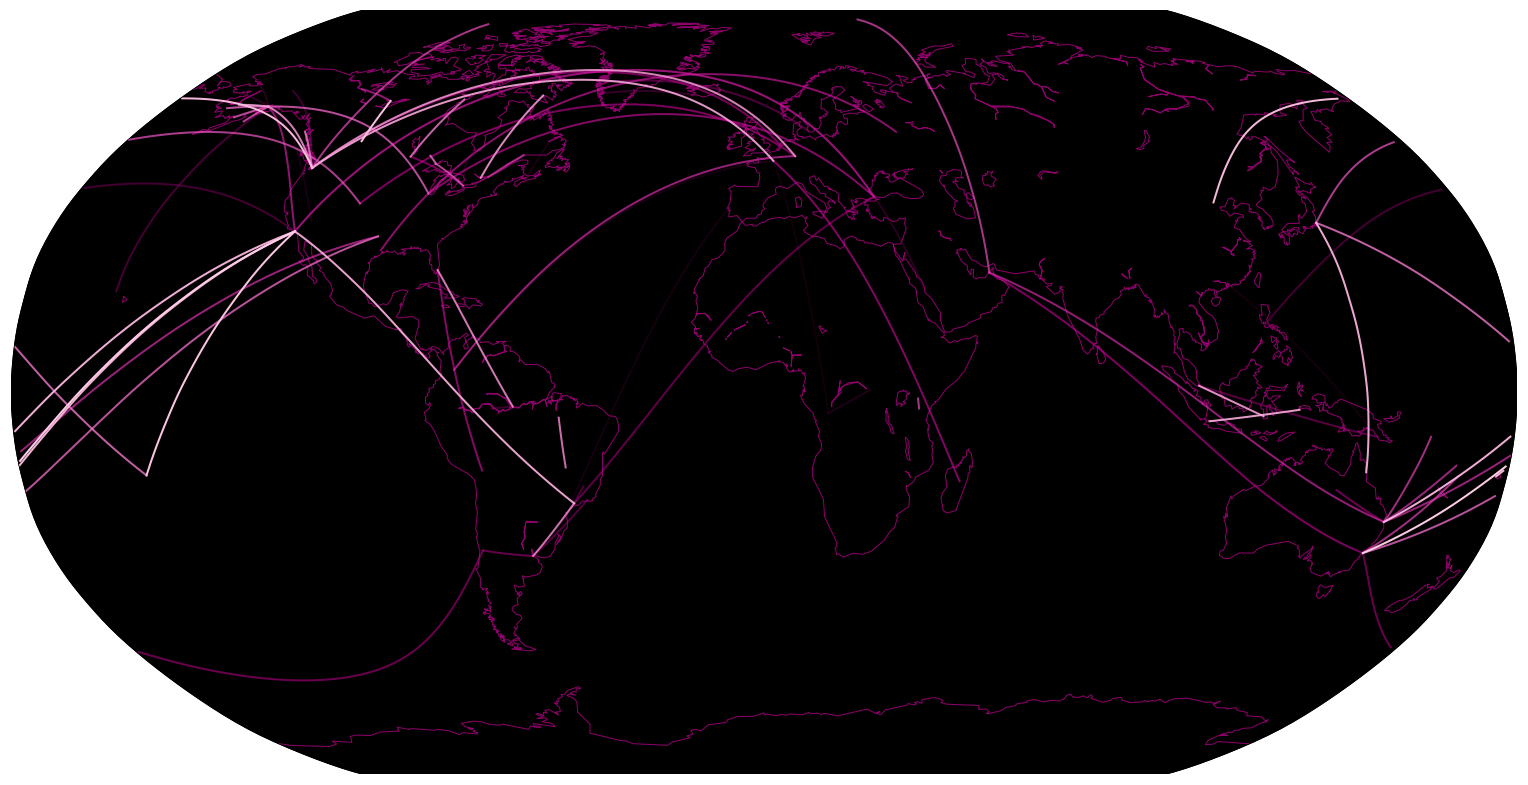

In [98]:
def plot_n_routes_betw(n, edge_betweenness):
    df = pd.DataFrame()
    sorts = sorted(edge_betweenness.items(), key= lambda k:k[1],reverse=True)[0:n]
    for c in sorts:
        routes[(routes["from"] == c[0][0]) & (routes["to"] == c[0][1])]
        df = df.append(routes[(routes["from"] == c[0][0]) & (routes["to"] == c[0][1])])
    
    plot_map(df)
    
    


sorts = sorted(betw.items(), key= lambda k:k[1],reverse=True)
a = sorts[0:20]
df = plot_n_routes_betw(100, edge_betw)


In [99]:
routes

from   to  count   Route  airport_id_source  \
0      AER  KZN      1  AERKZN               2965   
1      ASF  KZN      1  ASFKZN               2966   
2      CEK  KZN      1  CEKKZN               2968   
3      DME  KZN      4  DMEKZN               4029   
4      EGO  KZN      1  EGOKZN               6156   
5      LED  KZN      3  LEDKZN               2948   
6      SVX  KZN      1  SVXKZN               2975   
7      DWC  KZN      1  DWCKZN               8076   
8      FEG  KZN      1  FEGKZN               6149   
9      SKD  KZN      1  SKDKZN               2981   
10     UFA  KZN      1  UFAKZN               2992   
11     AYT  KZN      1  AYTKZN               1688   
12     SVO  KZN      1  SVOKZN               2985   
13     ALA  KZN      1  ALAKZN               2908   
14     DYU  KZN      2  DYUKZN               2979   
15     FRU  KZN      1  FRUKZN               2912   
16     IST  KZN      1  ISTKZN              13696   
17     LBD  KZN      2  LBDKZN               6147   
18     SHJ  KZN      1  SHJKZN               2191   
19     TAS  KZN      1  TASKZN               2983   
20     OSS  KZN      1  OSSKZN               2913   
21     AER  DYU      1  AERDYU               2965   
22     CEK  DYU      2  CEKDYU               2968   
23     DME  DYU      2  DMEDYU               4029   
24     KZN  DYU      2  KZNDYU               2990   
25     LED  DYU      4  LEDDYU               2948   
26     MRV  DYU      1  MRVDYU               2962   
27     NBC  DYU      1  NBCDYU               6969   
28     OVB  DYU      2  OVBDYU               4078   
29     SVX  DYU      3  SVXDYU               2975   
...    ...  ...    ...     ...                ...   
37012  VDS  BJF      1  VDSBJF               4328   
37013  HFT  HVG      1  HFTHVG               4325   
37014  MEH  HVG      1  MEHHVG               4327   
37015  YHR  ZTB      1  YHRZTB               5503   
37016  ZLT  ZTB      1  ZLTZTB               5474   
37017  WNN  SUR      1  WNNSUR               5466   
37018  YFH  YLH      1  YFHYLH               5491   
37019  YWP  YLH      1  YWPYLH               5533   
37020  YFH  YOG      1  YFHYOG               5491   
37021  YHP  YNO      1  YHPYNO               5471   
37022  YPM  YNO      1  YPMYNO               5521   
37023  YNO  YHP      1  YNOYHP               5467   
37024  YPM  YHP      1  YPMYHP               5521   
37025  YWP  YPL      1  YWPYPL               5533   
37026  ZSJ  KEW      1  ZSJKEW               5548   
37027  YAT  YPO      1  YATYPO               5482   
37028  YAT  ZKE      1  YATZKE               5482   
37029  YFA  ZKE      1  YFAZKE               5490   
37030  YKQ  YNS      1  YKQYNS               5507   
37031  YMT  YNS      1  YMTYNS               5514   
37032  YKQ  ZEM      1  YKQZEM               5507   
37033  YNC  ZEM      1  YNCZEM               5516   
37034  YKU  YNC      1  YKUYNC               5472   
37035  ZEM  YNC      1  ZEMYNC               5539   
37036  YMO  YFA      1  YMOYFA                 91   
37037  ZKE  YFA      1  ZKEYFA               5543   
37038  YPO  YAT      1  YPOYAT               5522   
37039  ZKE  YAT      1  ZKEYAT               5543   
37040  JCK  RCM      1  JCKRCM               6276   
37041  TRO  GFN      1  TROGFN               6794   

                      airport_name_source        city_source  \
0             Sochi International Airport              Sochi   
1                       Astrakhan Airport          Astrakhan   
2           Chelyabinsk Balandino Airport        Chelyabinsk   
3        Domodedovo International Airport             Moscow   
4          Belgorod International Airport           Belgorod   
5                         Pulkovo Airport     St. Petersburg   
6                        Koltsovo Airport      Yekaterinburg   
7        Al Maktoum International Airport              Dubai   
8           Fergana International Airport            Fergana   
9                       Samarkand Airport          Samarkand   
10             

In [26]:
[print(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]

DegreeView({'AER': 18, 'KZN': 21, 'ASF': 7, 'MRV': 16, 'CEK': 14, 'OVB': 53, 'DME': 190, 'NBC': 7, 'TGK': 1, 'UUA': 3, 'EGO': 9, 'KGD': 10, 'GYD': 39, 'LED': 113, 'SVX': 67, 'NJC': 9, 'NUX': 10, 'BTK': 4, 'IKT': 28, 'HTA': 9, 'KCK': 1, 'ODO': 1, 'UKX': 1, 'ULK': 2, 'YKS': 23, 'MJZ': 6, 'AYP': 1, 'LIM': 57, 'CUZ': 5, 'PEM': 2, 'HUU': 1, 'IQT': 4, 'PCL': 3, 'TPP': 3, 'ABJ': 21, 'BOY': 2, 'OUA': 15, 'ACC': 30, 'BKO': 16, 'DKR': 32, 'COO': 20, 'LFW': 16, 'NIM': 9, 'BOG': 74, 'GYE': 19, 'UIO': 26, 'CLO': 18, 'SCY': 1, 'OCC': 2, 'BDS': 19, 'ZRH': 137, 'BOD': 49, 'BRS': 73, 'GVA': 101, 'LPA': 83, 'LCA': 55, 'RMF': 4, 'TFS': 85, 'AJR': 1, 'LYC': 2, 'ARN': 124, 'GEV': 4, 'HAD': 4, 'JKG': 2, 'KRF': 2, 'KSD': 2, 'MHQ': 3, 'OER': 1, 'POR': 3, 'TRF': 30, 'VBY': 4, 'VHM': 2, 'VXO': 6, 'HMV': 1, 'KOK': 2, 'TKU': 7, 'OSL': 105, 'ADQ': 8, 'AOS': 2, 'KKB': 2, 'KLN': 2, 'KOZ': 2, 'OLH': 1, 'KZB': 1, 'SYB': 2, 'KYK': 1, 'ORI': 2, 'KPR': 1, 'BSO': 1, 'MNL': 78, 'BXU': 2, 'CBO': 1, 'CGY': 5, 'CRM': 1, 'DGT'

In [36]:
[print(c) for c in sorted(nx.degree(G), key= lambda k:k[1],reverse=True)]

('AMS', 248)
('FRA', 244)
('CDG', 240)
('IST', 236)
('ATL', 217)
('PEK', 207)
('ORD', 206)
('MUC', 192)
('DME', 190)
('DXB', 188)
('DFW', 188)
('LHR', 172)
('DEN', 170)
('IAH', 169)
('LGW', 165)
('BCN', 163)
('JFK', 162)
('FCO', 162)
('MAD', 159)
('PVG', 154)
('BRU', 153)
('STN', 153)
('EWR', 153)
('CAN', 150)
('LAX', 149)
('MAN', 148)
('DUS', 147)
('YYZ', 147)
('DUB', 144)
('SVO', 144)
('CLT', 141)
('VIE', 139)
('MIA', 138)
('ZRH', 137)
('DTW', 135)
('HKG', 134)
('ICN', 133)
('LAS', 133)
('MSP', 131)
('PMI', 127)
('IAD', 127)
('SIN', 125)
('ARN', 124)
('PHL', 123)
('ORY', 123)
('BKK', 122)
('CPH', 122)
('DOH', 118)
('AGP', 117)
('LED', 113)
('MXP', 113)
('KUL', 112)
('JED', 111)
('TXL', 110)
('CTU', 108)
('OSL', 105)
('SFO', 105)
('ATH', 104)
('NRT', 104)
('TPE', 103)
('LIS', 103)
('BOS', 103)
('MCO', 102)
('GVA', 101)
('SAW', 98)
('DEL', 98)
('FLL', 97)
('YUL', 96)
('ALC', 96)
('KMG', 95)
('MEX', 95)
('PRG', 94)
('SEA', 94)
('CMN', 93)
('CGN', 93)
('GRU', 92)
('SLC', 92)
('PHX', 91)


('YAM', 4)
('YBC', 4)
('YFC', 4)
('ZSA', 4)
('CKS', 4)
('PVH', 4)
('JOI', 4)
('PFB', 4)
('XAP', 4)
('HUN', 4)
('KNH', 4)
('MZG', 4)
('BGF', 4)
('EBU', 4)
('NBS', 4)
('BJA', 4)
('BLJ', 4)
('GHA', 4)
('TLM', 4)
('SDK', 4)
('SOC', 4)
('TGG', 4)
('DGO', 4)
('SLA', 4)
('CDB', 4)
('LWS', 4)
('PEI', 4)
('HUY', 4)
('REG', 4)
('TGM', 4)
('BQN', 4)
('SRY', 4)
('PLZ', 4)
('MZV', 4)
('JXA', 4)
('BMV', 4)
('CXR', 4)
('GOM', 4)
('CYO', 4)
('GYS', 4)
('FNJ', 4)
('HLH', 4)
('JIU', 4)
('NDG', 4)
('RLK', 4)
('TAE', 4)
('WUA', 4)
('BUA', 4)
('UNG', 4)
('GKA', 4)
('GUR', 4)
('PNP', 4)
('WWK', 4)
('ENY', 4)
('SDL', 4)
('UTH', 4)
('DLH', 4)
('IDA', 4)
('KSC', 4)
('MOT', 4)
('KZO', 4)
('TJU', 4)
('LRE', 4)
('BUZ', 4)
('KDH', 4)
('KER', 4)
('LLI', 4)
('BKG', 4)
('PGA', 4)
('TBU', 4)
('SHP', 4)
('GXF', 4)
('HOD', 4)
('PMF', 4)
('LBC', 4)
('FNI', 4)
('OSI', 4)
('PZU', 4)
('YNG', 4)
('PGK', 4)
('PLW', 4)
('PNK', 4)
('JIC', 4)
('CJC', 4)
('LSC', 4)
('ARI', 4)
('BHV', 4)
('MLN', 4)
('ABA', 4)
('GDX', 4)
('YSM', 4)

('YPY', 2)
('AGN', 2)
('TKE', 2)
('ELV', 2)
('GST', 2)
('HNH', 2)
('HNS', 2)
('SGY', 2)
('PEC', 2)
('RDN', 2)
('YWH', 2)
('HLA', 2)
('MMJ', 2)
('AGT', 2)
('RIG', 2)
('ASJ', 2)
('MSJ', 2)
('UBJ', 2)
('PPP', 2)
('MCY', 2)
('KBU', 2)
('MOF', 2)
('BSA', 2)
('YYU', 2)
('CAP', 2)
('XSC', 2)
('WWP', 2)
('KPB', 2)
('PPV', 2)
('NKI', 2)
('MKL', 2)
('IPL', 2)
('HOT', 2)
('HRO', 2)
('OTH', 2)
('HIN', 2)
('KWJ', 2)
('RSU', 2)
('USN', 2)
('KPO', 2)
('LPI', 2)
('LYB', 2)
('IPC', 2)
('TCQ', 2)
('MPN', 2)
('ZOS', 2)
('EOI', 2)
('SOY', 2)
('WRY', 2)
('LAQ', 2)
('SRX', 2)
('ESD', 2)
('DHB', 2)
('RCE', 2)
('WSX', 2)
('FRD', 2)
('FBS', 2)
('OZH', 2)
('MJN', 2)
('FTU', 2)
('MOQ', 2)
('BBN', 2)
('KUD', 2)
('MKM', 2)
('LGL', 2)
('LKH', 2)
('ODN', 2)
('YGX', 2)
('BYN', 2)
('GOQ', 2)
('NGQ', 2)
('NYT', 2)
('JHM', 2)
('ORZ', 2)
('JBQ', 2)
('AWD', 2)
('FTA', 2)
('LNB', 2)
('DLY', 2)
('LOD', 2)
('LPM', 2)
('SWJ', 2)
('PBJ', 2)
('SHB', 2)
('WKJ', 2)
('FUJ', 2)
('TSJ', 2)
('CFC', 2)
('SRA', 2)
('GIS', 2)
('PPQ', 2)

('SKO', 1)
('YOL', 1)
('JOS', 1)
('KAD', 1)
('QUO', 1)
('ANS', 1)
('ATA', 1)
('JAU', 1)
('TGI', 1)
('ARW', 1)
('KYP', 1)
('PBU', 1)
('KME', 1)
('SKE', 1)
('NVK', 1)
('RRS', 1)
('EUX', 1)
('YBR', 1)
('YOG', 1)
('KHS', 1)
('EXI', 1)
('KAE', 1)
('APF', 1)
('IAA', 1)
('TGP', 1)
('THX', 1)
('KGP', 1)
('TQL', 1)
('YPO', 1)
('MCM', 1)
('GCN', 1)
('BDP', 1)
('BHR', 1)
('BIR', 1)
('BWA', 1)
('DHI', 1)
('JKR', 1)
('KEP', 1)
('PKR', 1)
('TMI', 1)
('KWF', 1)
('UYU', 1)
('BFF', 1)
('CEZ', 1)
('EAR', 1)
('LBF', 1)
('MCK', 1)
('RIW', 1)
('SHR', 1)
('MCE', 1)
('PRC', 1)
('VIS', 1)
('SVC', 1)
('CED', 1)
('CPD', 1)
('KGC', 1)
('WYA', 1)
('GFN', 1)
('RCM', 1)
('LSY', 1)
('OAG', 1)


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [51]:
 largest_cc = max(nx.connected_components(G), key=len)

In [96]:
graphs = list(nx.connected_component_subgraphs(G))
G1 = graphs[0]


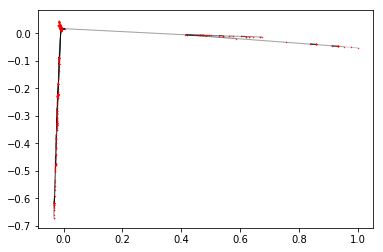

In [61]:
pos_spring = nx.spectral_layout(G1)
nx.draw_networkx_nodes(G1, pos_spring, node_size = 0.2)
nx.draw_networkx_edges(G1, pos_spring, alpha=0.2)
plt.show()

In [25]:
periphery_nodes = nx.periphery(G1)
lengths_to_places = nx.shortest_path_length(G1, periphery_nodes[2])

In [27]:
#[print(c) for c in sorted(a, key= lambda k:k[1])]
max(lengths_to_places, key=lengths_to_places.get)
periphery_nodes[2]

'YZG'

In [28]:
nx.shortest_path(G1, 'YZG', "QUV")

['YZG',
 'YIK',
 'AKV',
 'YPX',
 'YGL',
 'YUL',
 'ZRH',
 'KEF',
 'GOH',
 'UAK',
 'JJU',
 'JNN',
 'QFN',
 'QUV']

In [29]:
lengths_to_helsinki = nx.shortest_path_length(G1, "HEL")

In [39]:
routes
airports

0                                            1   \
0         1                               Goroka Airport   
1         2                               Madang Airport   
2         3                 Mount Hagen Kagamuga Airport   
3         4                               Nadzab Airport   
4         5  Port Moresby Jacksons International Airport   
5         6                  Wewak International Airport   
6         7                           Narsarsuaq Airport   
7         8                      Godthaab / Nuuk Airport   
8         9                        Kangerlussuaq Airport   
9        10                               Thule Air Base   
10       11                             Akureyri Airport   
11       12                          Egilsstaðir Airport   
12       13                         Hornafjörður Airport   
13       14                              Húsavík Airport   
14       15                           Ísafjörður Airport   
15       16               Keflavik International Airport   
16       17                       Patreksfjörður Airport   
17       18                            Reykjavik Airport   
18       19                         Siglufjörður Airport   
19       20                       Vestmannaeyjar Airport   
20       21                      Sault Ste Marie Airport   
21       22               Winnipeg / St. Andrews Airport   
22       23            Halifax / CFB Shearwater Heliport   
23       24                          St. Anthony Airport   
24       25                  Tofino / Long Beach Airport   
25       26                             Kugaaruk Airport   
26       27                          Baie Comeau Airport   
27       28                               CFB Bagotville   
28       29                           Baker Lake Airport   
29       30                       Campbell River Airport   
...     ...                                          ...   
7668  13821                               Gitega Airport   
7669  13829       Región de Murcia International Airport   
7670  13830                     Fazenda Kajussol Airport   
7671  13880                         Pelee Island Airport   
7672  13881                        Costa Marques Airport   
7673  13891                            Mangalore Airport   
7674  14086               San Isidro del General Airport   
7675  14087                               Zabrat Airport   
7676  14088                              Bezmer Air Base   
7677  14089                             Osovtsy Air Base   
7678  14090                             Yuanmou Air Base   
7679  14091                 Changsha Datuopu Airport/AFB   
7680  14092                           Xingcheng Air Base   
7681  14093                            Lefkoniko Airport   
7682  14095                               Songwe Airport   
7683  14096                        Kalocsa/Foktő Airport   
7684  14097                       Bilogai-Sugapa Airport   
7685  14098                             Jakkur Aerodrome   
7686  14099                           Jalal-Abad Airport   
7687  14100                                Ramon Airport   
7688  14101                               Rustaq Airport   
7689  14102                         Laguindingan Airport   
7690  14103                          Kostomuksha Airport   
7691  14104                        Privolzhskiy Air Base   
7692  14105                             Kubinka Air Base   
7693  14106                          Rogachyovo Air Base   
7694  14107                        Ulan-Ude East Airport   
7695  14108                         Krechevitsy Air Base   
7696  14109                  Desierto de Atacama Airport   
7697  14110                           Melitopol Air Base   

                         2                 3    4     5          6   \
0                    Goroka  Papua New Guinea  GKA  AYGA  -6.081690   
1                    Madang  Papua New Guinea  MAG  AYMD  -5.207080   
2               Mount Hagen  Papua New Guinea  HGU  AYMH  -5.826790   
3   

In [33]:
### ANALYSIS OF HELSINKI ###

lengths_to_helsinki.values()

dict_values([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 